## PG Multipliers Experiment

In [1]:
import snowflake.connector
import pandas as pd
import seaborn as sns
from snowflake.connector import DictCursor
import json
import warnings
import numpy as np
import matplotlib.pyplot as plt
from causalimpact import CausalImpact
with open("/Users/jeremyconover/Documents/creds.json") as f:
  SNOWFLAKE_INFO = json.load(f)
db_con = snowflake.connector.connect(**SNOWFLAKE_INFO, authenticator='externalbrowser')
cur = db_con.cursor(DictCursor)
pd.set_option('display.max_columns', 500)
sns.set_theme()
warnings.filterwarnings("ignore")

#Function to executre SQL queries
def run_sql_query(query):
    return pd.DataFrame(cur.execute(query).fetchall())

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


In [2]:
#Function to get pre and post periods for CI and DiD
def set_date_ranges(test_start,test_end,data_start,df_exp, ratio = 2, baking_prd = 0):
    #make training period ratio*x testing period
    pre_period_start = pd.to_datetime(test_start) - (pd.to_datetime(test_end) -  pd.to_datetime(test_start)) * ratio
    if pre_period_start < pd.to_datetime(data_start):
        pre_period_start = pd.to_datetime(data_start)
    pre_period_start = pre_period_start.strftime('%Y-%m-%d')
    pre_period_end = (pd.to_datetime(test_start) - pd.Timedelta(days = 1)).strftime('%Y-%m-%d')
    post_period_start = test_start
    if pd.to_datetime(test_end) > pd.to_datetime(df_exp.DAY.max()):
        post_period_end = pd.to_datetime(df_exp.DAY.max()) - pd.Timedelta(days = baking_prd)
    else:
        post_period_end = pd.to_datetime(test_end) - pd.Timedelta(days = baking_prd)
    post_period_end = post_period_end.strftime('%Y-%m-%d')
    return pre_period_start, pre_period_end, post_period_start, post_period_end

In [54]:
#parameters
data_start = '2023-05-25' ##2023-07-17 ## '2023-08-04'
test_start =  '2023-06-26' ## '2023-08-25'
test_end = '2023-07-05'##2023-08-02 ##'2023-09-10'##
locales = ['en-US']
test_metros = ['SF Bay Area','Washington DC','Boston','Chicago', 'LA & OC', 'New York City']
##test_metros= ['Washington DC','Atlanta','Boston','Austin','Dallas/Fort Worth','Denver','Las Vegas','Nashville']
control_metros = ['Philadelphia','Dallas/Fort Worth','Denver','Atlanta','Seattle','Austin','Miami']
##control_metros = ['Chicago','Phoenix','Philadelphia','Miami','San Diego','Seattle','Charlotte','Raleigh/Durham']
cat_ids = [6,413]  
##cat_ids = [401, 8]  
##33cat_ids = [33,405,6] 
##cat_ids = '33' 

In [3]:
#parameters2
data_start2 = '2023-06-01'
test_start2 = '2023-07-01'
test_end2 = '2023-09-01'
locales = ['en-US']
test_metros2 = ['SF Bay Area','Washington DC', 'New York City']
##test_metros= ['Washington DC','Atlanta','Boston','Austin','Dallas/Fort Worth','Denver','Las Vegas','Nashville']
control_metros2 =  ['LA & OC', 'Chicago', 'Boston']  
#control_metros2 = ['Philadelphia','Dallas/Fort Worth','Denver','Atlanta','Seattle','Austin','Miami']
## other tier twos: Philadelphia, Houston, San Diego, Portland
##control_metros = ['Chicago','Phoenix','Philadelphia','Miami','San Diego','Seattle','Charlotte','Raleigh/Durham']
cat_ids2 = [59,33]  
##cat_ids = [401, 8]  
##33cat_ids = [33,405,6] 
##cat_ids = '33' 

In [55]:
##pull data for main metrics
query_rev_per_visitor = f"""with a as (
select 
DISTINCT
metros.name as METRO_NAME
,date_trunc('DAY', dateadd(minute,0,dateadd(hour,0,jr.created_at))) as DAY
,jr.GUID as reco_guid
,case when jobs.id is NULL then NULL else jr.GUID end as jobs_guid
,case when ji.id is NULL then NULL else jr.GUID end as invoice_guid
,jr.recommendation_id 
,case when jobs.id is NULL then 0 else 1 end as job_booked
,case when ji.id is NULL then 0 else 1 end as invoiced
,ji.REVENUE_CENTS
,case when jr.is_first_booking then jr.GUID else NULL end as new_visitor
,case when jr.is_first_booking and jobs.id is not null then jr.GUID else NULL end as new_visitor_job

from job_recommendations jr
left join jobs on jobs.recommendation_id = jr.recommendation_id
LEFT JOIN job_invoices ji ON jobs.id = ji.job_id
LEFT JOIN geographies metros ON COALESCE(jr.metro_id, jr.geography_id)  = metros.id 

where 
jr.created_at >= '{data_start}'
and  (jobs.suppress_level < 1000 OR jobs.suppress_level is NULL)
and jr.locale in {*locales,''}
and jr.category_id  in {*cat_ids,}   ---- checking the not these
and metros.LEVEL = 'metro'
and metros.ACTIVE = 1
and (metros.name in {*test_metros,} or metros.name in {*control_metros,})
)

select
METRO_NAME
,DAY
,COUNT(DISTINCT reco_guid) as RECO_VISITORS_UNIQUE
,COUNT(DISTINCT jobs_guid) as JOBS_VISITORS_UNIQUE
,COUNT(DISTINCT invoice_guid) as INVOICE_VISITORS_UNIQUE
,COUNT(DISTINCT RECOMMENDATION_ID) as RECOS
,SUM(JOB_BOOKED) as JOBS
,SUM(invoiced) as INVOICES
,SUM(REVENUE_CENTS) as REVENUE
,COUNT(distinct new_visitor) as NEW_RECO_VISITORS
,COUNT(distinct new_visitor_job) as NEW_JOB_VISITORS
,COUNT(DISTINCT reco_guid) - COUNT(distinct new_visitor) as RETURN_RECO_VISITORS
,COUNT(DISTINCT jobs_guid) - COUNT(distinct new_visitor_job) as RETURN_JOB_VISITORS

from a 
group by 1,2
order by 2,4 desc"""

query_rates = f"""
with rates as (
select 
jr.created_at as created_at,
jr.recommendation_id,
jrr.POSITION,
jrr.category_invoice_count,
LEAST(jr.NUMBER_OF_RESULTS,50) as MAX_POSITION,
to_double(LEAST(jr.NUMBER_OF_RESULTS,50)) as FACES,
to_double(jrr.poster_hourly_rate_cents / 100.0) as client_rate,
to_double(jrr.rabbit_hourly_rate_cents / 100.0) as rabbit_rate,
to_double(jrr.RECOMMENDED_PRICE_CENTS / 100.0) as recommended_rate,
metros.name  as metro_name,
metros.id as metro_id

from job_recommendation_recommendations jrr 
LEFT JOIN job_recommendations jr ON jr.recommendation_id = jrr.recommendation_id
LEFT JOIN categories  ON jr.category_id  = categories.id
LEFT JOIN geographies  AS metros ON COALESCE(jr.metro_id, jr.geography_id)  = metros.id

WHERE jr.created_at  >= '{data_start}' and
(jrr.position  < 50) AND (jr.locale in {*locales,''})
  AND jr.last_in_funnel
  and jr.category_id  in {*cat_ids,}  ----- checking the not ins
),

rates_8 as (
select 
jr.created_at as created_at,
jr.recommendation_id,
jrr.POSITION,
jrr.category_invoice_count,
LEAST(jr.NUMBER_OF_RESULTS,50) as MAX_POSITION,
to_double(LEAST(jr.NUMBER_OF_RESULTS,50)) as FACES,
to_double(jrr.poster_hourly_rate_cents / 100.0) as client_rate,
to_double(jrr.rabbit_hourly_rate_cents / 100.0) as rabbit_rate,
to_double(jrr.RECOMMENDED_PRICE_CENTS / 100.0) as recommended_rate,
metros.name  as metro_name,
metros.id as metro_id

from job_recommendation_recommendations jrr 
LEFT JOIN job_recommendations jr ON jr.recommendation_id = jrr.recommendation_id
LEFT JOIN categories  ON jr.category_id  = categories.id
LEFT JOIN geographies  AS metros ON COALESCE(jr.metro_id, jr.geography_id)  = metros.id

WHERE jr.created_at  >= '{data_start}' and
(jrr.position  < 9) AND (jr.locale in {*locales,''})
  AND jr.last_in_funnel
  and jr.category_id in {*cat_ids,}  ----- checking the not ins
)

select
date_trunc('day', rates.created_at) as day,
rates.recommendation_id,
rates.metro_name,
rates.metro_id,
sum(rates.rabbit_rate * w.invoice_pct) as rabbit_px_wt,
sum(rates.client_rate * w.invoice_pct) as client_px_wt,
sum(rates.recommended_rate * w.invoice_pct) as pg_px_wt,
sum(rates.category_invoice_count * w.invoice_pct) as wt_cat_experience, ---was weight not invpct
avg(rates.rabbit_rate) as rabbit_rate_avg,
avg(rates.client_rate) as client_rate_avg,
avg(rates.recommended_rate) as pg_rate_avg,
avg(rates.FACES) as FACES,
--avg(rates_8.recommended_rate) as pg_rate_top_8,
--avg(rates_8.rabbit_rate) as rabbit_rate_top_8
1 as pg_rate_top_8,
1 as rabbit_rate_top_8 ---- seeing if these were causing trouble

from
rates 
left join playground.JJC_INV_WGT w on w.number_of_results = rates.MAX_POSITION and w.POSITION2 = rates.POSITION
--left join rates_8 on rates.recommendation_id = rates_8.recommendation_id 
 group by 1,2,3,4
"""

query_invites = f"""
select
DISTINCT
metros.name as METRO_NAME
,date_trunc('DAY', dateadd(minute,0,dateadd(hour,0,jr.created_at))) as DAY
,jr.recommendation_id 
,case when jobs.id is NULL then 0 else 1 end as job_booked
,case when ji.id is NULL then 0 else 1 end as invoiced
,to_double(invitations.poster_hourly_rate_cents/100.0) as poster_hourly_rate_cents
,to_double(invitations.rabbit_hourly_rate_cents/100.0) as rabbit_hourly_rate_cents
,ji.REVENUE_CENTS
,pt.normalized_service_fee_in_cents + normalized_owner_trust_fee_in_cents + normalized_worker_fee_in_cents as ORDER_VALUE
,invitations.rabbit_category_experience
,jrr.recommended_price_cents as pg_rate_cents


from invitations 
LEFT JOIN job_recommendations jr ON jr.recommendation_id = invitations.recommendation_id 
left join jobs on jobs.recommendation_id = jr.recommendation_id
left join job_recommendation_recommendations jrr on jrr.recommendation_id = jr.recommendation_id 
        and invitations.rabbit_id = jrr.user_id
LEFT JOIN job_invoices ji ON jobs.id = ji.job_id
LEFT JOIN geographies metros ON COALESCE(jr.metro_id, jr.geography_id)  = metros.id 
LEFT JOIN payment_transactions pt ON pt.ID = ji.PAYMENT_TRANSACTION_ID

where last_in_funnel 
and jr.created_at >= '{data_start}'
and jr.created_at < current_date()
and  (jobs.suppress_level < 1000 OR jobs.suppress_level is NULL)
and jr.locale in {*locales,''}
and jr.category_id  in {*cat_ids,}  ----- checking the not ins
and (metros.name in {*test_metros,} or metros.name in {*control_metros,})
"""


In [56]:
def add_cohorts(df_rpv,test_metros,control_metros):
    df_rpv['COHORT'] = None
    df_rpv['COHORT'] = np.where(df_rpv.METRO_NAME.isin(test_metros), 'TREATMENT',df_rpv.COHORT)
    df_rpv['COHORT'] = np.where(df_rpv.METRO_NAME.isin(control_metros), 'CONTROL',df_rpv.COHORT)
    df_rpv = df_rpv[~df_rpv.COHORT.isna()]
    return df_rpv

In [59]:
def make_ts_df(df_rpv, df_invites):
    """create experiment dataframe
       group by cohort/day to transform necessary variables
    """
    df_gb = pd.DataFrame(df_rpv.groupby(['COHORT','DAY'])['REVENUE'].sum()/df_rpv.groupby(['COHORT','DAY'])['RECO_VISITORS_UNIQUE'].sum()).reset_index()
    df_gb.columns = ['COHORT','DAY','REVENUE_PER_VISITOR']
    df_gb['REVENUE_PER_VISITOR'] = round(df_gb['REVENUE_PER_VISITOR'].astype(float) / 100,2)
    df_gb2 = pd.DataFrame(df_rpv.groupby(['COHORT','DAY'])['JOBS_VISITORS_UNIQUE'].sum()/df_rpv.groupby(['COHORT','DAY'])['RECO_VISITORS_UNIQUE'].sum()).reset_index()
    df_gb2.columns = ['COHORT','DAY','JOBS_RATE']
    df_gb21 = pd.DataFrame(df_rpv.groupby(['COHORT','DAY'])['JOBS_VISITORS_UNIQUE'].sum()/df_rpv.groupby(['COHORT','DAY'])['RECOS'].sum()).reset_index()
    df_gb21.columns = ['COHORT','DAY','JOBS_RATE2']
    df_gb3 = pd.DataFrame(df_rpv.groupby(['COHORT','DAY'])['INVOICE_VISITORS_UNIQUE'].sum()/df_rpv.groupby(['COHORT','DAY'])['RECO_VISITORS_UNIQUE'].sum()).reset_index()
    df_gb3.columns = ['COHORT','DAY','INVOICE_RATE']
    df_gb_cr = pd.DataFrame(df_rpv.groupby(['COHORT','DAY'])['INVOICE_VISITORS_UNIQUE'].sum()/df_rpv.groupby(['COHORT','DAY'])['JOBS_VISITORS_UNIQUE'].sum()).reset_index()
    df_gb_cr.columns = ['COHORT','DAY','CLOSE_RATE']
    #df_gb4 = df_rates.groupby(['COHORT','DAY'], as_index = False)['PG_RATE_TOP_8','RABBIT_RATE_TOP_8','CLIENT_RATE_AVG','RABBIT_RATE_AVG','PG_RATE_AVG','CLIENT_PX_WT','RABBIT_PX_WT','PG_PX_WT','FACES','WT_CAT_EXPERIENCE'].mean()
   # df_gb4 = df_gb4.rename(columns = {'CLIENT_RATE_AVG':'CLIENT_PX_SHOWN_AVG','RABBIT_RATE_AVG':'RABBIT_PX_SHOWN_AVG','PG_RATE_AVG':'PG_PX_SHOWN_AVG'})
   # df_gb4 = df_gb4.rename(columns = {'CLIENT_PX_WT':'CLIENT_PX_SHOWN_WT','RABBIT_PX_WT':'RABBIT_PX_SHOWN_WT','PG_PX_WT':'PG_PX_SHOWN_WT','FACES':'AVG_FACES'})
    df_gb5 = df_invites.groupby(['COHORT','DAY'], as_index = False)[['ORDER_VALUE','POSTER_HOURLY_RATE_CENTS','RABBIT_HOURLY_RATE_CENTS','RABBIT_CATEGORY_EXPERIENCE','PG_RATE_CENTS']].mean()
    df_gb5 = df_gb5.rename(columns = {'PG_RATE_CENTS':'AVG_INVITE_PG','ORDER_VALUE':'AOV','POSTER_HOURLY_RATE_CENTS':'AVG_INVITE_CLIENT_PX','RABBIT_HOURLY_RATE_CENTS':'AVG_INVITE_RABBIT_PX','RABBIT_CATEGORY_EXPERIENCE':'AVG_INVITE_CAT_EXP'})
    df_tracking = df_gb.merge(df_gb2).merge(df_gb3).merge(df_rpv.groupby(['COHORT','DAY'], as_index = False)['RECOS','JOBS','INVOICES'].sum())
    df_tracking = df_tracking.merge(df_gb5)
    df_tracking = df_tracking.merge(df_gb_cr, how = 'left')
    df_tracking = df_tracking.merge(pd.DataFrame(df_rpv.groupby(['COHORT','DAY'],as_index = False)['REVENUE'].sum()))
    df_gb_rr = pd.DataFrame(df_rpv.groupby(['COHORT','DAY'])['REVENUE'].sum()/df_rpv.groupby(['COHORT','DAY'])['RECOS'].sum()).reset_index()
    df_gb_rr.columns = ['COHORT','DAY','REVENUE_PER_RECO']
    df_tracking = df_tracking.merge(df_gb_rr, how = 'left')
    df_gbb = pd.DataFrame(df_rpv.groupby(['COHORT','DAY'])['RECOS'].sum()/df_rpv.groupby(['COHORT','DAY'])['RECO_VISITORS_UNIQUE'].sum()).reset_index()
    df_gbb.columns = ['COHORT','DAY','RECO_PER_VISITOR']
    df_tracking = df_tracking.merge(df_gbb, how = 'left')
    df_tracking = df_tracking.merge(df_gb21, how = 'left')
    return df_tracking

In [60]:
df_rpv = run_sql_query(query_rev_per_visitor)
#df_rates = run_sql_query(query_rates)
df_invites = run_sql_query(query_invites)
df_rpv2 = add_cohorts(df_rpv,test_metros,control_metros)
#df_rates2 = add_cohorts(df_rates,test_metros,control_metros)
df_invites2 = add_cohorts(df_invites, test_metros,control_metros)
df_exp = make_ts_df(df_rpv2,df_invites2)

In [61]:
df_exp.columns

Index(['COHORT', 'DAY', 'REVENUE_PER_VISITOR', 'JOBS_RATE', 'INVOICE_RATE',
       'RECOS', 'JOBS', 'INVOICES', 'AOV', 'AVG_INVITE_CLIENT_PX',
       'AVG_INVITE_RABBIT_PX', 'AVG_INVITE_CAT_EXP', 'AVG_INVITE_PG',
       'CLOSE_RATE', 'REVENUE', 'REVENUE_PER_RECO', 'RECO_PER_VISITOR',
       'JOBS_RATE2'],
      dtype='object')

## Plot Series

In [62]:
def plot_cols(df_exp, col_name, experiment_date = test_start, max_date = None):
    if max_date:
        df_exp2 = df_exp[df_exp.DAY <= max_date]
    else:
        
        df_exp2 = df_exp.copy()
    print(f'corr = {np.corrcoef(df_exp2[df_exp2.COHORT == "CONTROL"][col],df_exp2[df_exp2.COHORT == "TREATMENT"][col])[0][1]}')
    fig,ax = plt.subplots(figsize = (15,5))
    ax = sns.lineplot(data=df_exp2, x="DAY", y=col, hue="COHORT")
    if experiment_date:
        plt.axvline(x = pd.to_datetime(experiment_date), color='black')

corr = 0.540644087271167


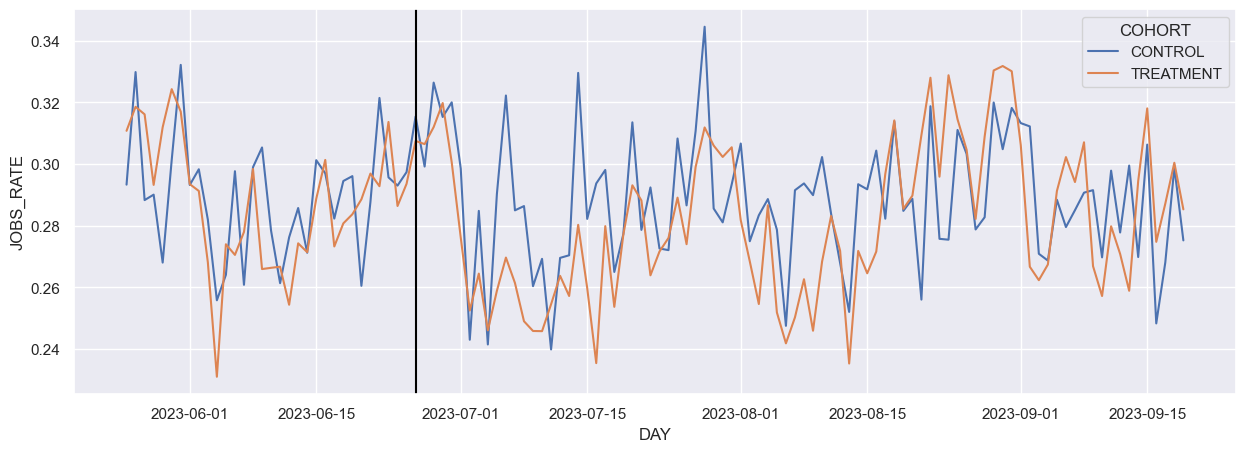

In [63]:
col =  'JOBS_RATE'
plot_cols(df_exp, col)

In [46]:
df_exp

,COHORT,DAY,REVENUE_PER_VISITOR,JOBS_RATE,INVOICE_RATE,RECOS,JOBS,INVOICES,PG_RATE_TOP_8,RABBIT_RATE_TOP_8,CLIENT_PX_SHOWN_AVG,RABBIT_PX_SHOWN_AVG,PG_PX_SHOWN_AVG,CLIENT_PX_SHOWN_WT,RABBIT_PX_SHOWN_WT,PG_PX_SHOWN_WT,AVG_FACES,AOV,AVG_INVITE_CLIENT_PX,AVG_INVITE_RABBIT_PX,AVG_INVITE_CAT_EXP,AVG_INVITE_PG,CLOSE_RATE,REVENUE,REVENUE_PER_RECO,RECO_PER_VISITOR,JOBS_RATE2
0,CONTROL,2023-05-25,9.07,0.293300,0.190898,2876,297,157,1.0,1.0,60.941015,59.032034,51.948988,60.220557,58.334003,57.076119,35.982775,15472.121019,53.093872,51.430976,162.848485,5358.922559,0.650862,717090.0,249.335883,3.635904,0.080668
1,CONTROL,2023-05-26,9.27,0.329829,0.191853,3026,323,156,1.0,1.0,59.534331,57.669599,52.191418,59.026208,57.177107,56.692413,36.145814,15348.903226,54.951558,53.230530,199.448598,5538.317757,0.581673,705332.0,233.090549,3.976347,0.082948
2,CONTROL,2023-05-27,7.78,0.288288,0.163664,2842,263,119,1.0,1.0,60.910938,59.002914,52.259436,58.599251,56.763635,56.266763,32.709783,14677.554622,51.561255,49.946768,161.585551,5227.756654,0.567708,518362.0,182.393385,4.267267,0.067558
3,CONTROL,2023-05-28,6.94,0.290051,0.158516,2225,221,99,1.0,1.0,61.015299,59.104101,52.399815,59.456969,57.594557,56.540769,34.770186,14098.676768,52.382443,50.742081,163.737557,5269.683258,0.546512,411504.0,184.945618,3.752108,0.077303
4,CONTROL,2023-05-29,6.38,0.268012,0.132565,2389,216,97,1.0,1.0,60.800824,58.896469,52.662115,59.608702,57.741796,56.583495,35.398200,15260.385417,53.359116,51.688372,179.948837,5386.511628,0.494624,442470.0,185.211386,3.442363,0.077857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,TREATMENT,2023-09-13,5.85,0.258874,0.140759,6058,526,238,1.0,1.0,65.851862,63.788679,57.933387,68.195541,66.058400,62.566313,43.048316,13974.382353,55.085314,53.360000,505.659048,5812.190476,0.543735,955776.0,157.770881,3.707466,0.069825
228,TREATMENT,2023-09-14,7.35,0.294479,0.153988,6374,613,274,1.0,1.0,64.559512,62.536950,57.687059,66.896488,64.800063,62.528126,42.250474,15004.062044,56.413181,54.646003,561.378467,5942.320261,0.522917,1197843.0,187.926420,3.910429,0.075306
229,TREATMENT,2023-09-15,6.99,0.318041,0.145691,6786,632,244,1.0,1.0,65.298325,63.252550,58.469139,68.148112,66.012402,64.334404,41.613411,15972.551440,57.009603,55.223810,579.106349,6108.730159,0.458090,1126823.0,166.051135,4.207068,0.075597
230,TREATMENT,2023-09-16,5.65,0.274747,0.113805,6083,524,175,1.0,1.0,65.418410,63.368911,57.914177,67.176333,65.071360,63.323708,40.540183,16582.462857,55.937061,54.185115,553.097328,5902.671756,0.414216,838808.0,137.893802,4.096296,0.067072


corr = 0.5144267594001525


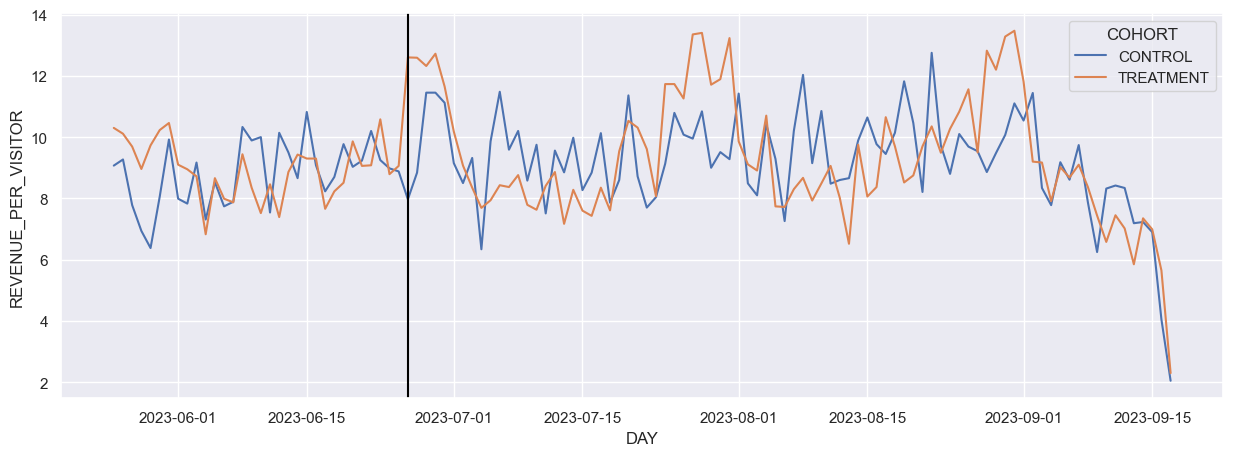

In [47]:
col =  'REVENUE_PER_VISITOR'
plot_cols(df_exp, col)

In [34]:
df_exp.columns

Index(['COHORT', 'DAY', 'REVENUE_PER_VISITOR', 'JOBS_RATE', 'INVOICE_RATE',
       'RECOS', 'JOBS', 'INVOICES', 'PG_RATE_TOP_8', 'RABBIT_RATE_TOP_8',
       'CLIENT_PX_SHOWN_AVG', 'RABBIT_PX_SHOWN_AVG', 'PG_PX_SHOWN_AVG',
       'CLIENT_PX_SHOWN_WT', 'RABBIT_PX_SHOWN_WT', 'PG_PX_SHOWN_WT',
       'AVG_FACES', 'AOV', 'AVG_INVITE_CLIENT_PX', 'AVG_INVITE_RABBIT_PX',
       'AVG_INVITE_CAT_EXP', 'AVG_INVITE_PG', 'CLOSE_RATE', 'REVENUE',
       'REVENUE_PER_RECO', 'RECO_PER_VISITOR', 'JOBS_RATE2'],
      dtype='object')

## Run Causal Impact

* set prior_level_sd = None or .01
* use nseasons = [{'period':7}] for columns with clear weekly seasonality (ex: JOBS_RATE)

In [64]:
#get periods for pre and post
pre_period_start, pre_period_end, post_period_start, post_period_end = set_date_ranges(test_start,test_end,data_start,df_exp, ratio = 2, baking_prd = 0)

In [69]:
#col = 'AVG_INVITE_RABBIT_PX'
#col = 'RABBIT_PX_SHOWN_WT'
#col = 'PG_PX_SHOWN_WT'
col = 'REVENUE_PER_VISITOR'
#col = 'JOBS_RATE'
#col = 'JOBS'
#col = 'REVENUE' 
#col = 'REVENUE_PER_RECO'
#col = 'INVOICE_RATE'
#col = 'AVG_INVITE_PG'

data = df_exp[df_exp.COHORT == 'TREATMENT'][['DAY',col]].rename(columns = {col:'y'}).set_index('DAY')
data = data.join(df_exp[df_exp.COHORT == 'CONTROL'][['DAY',col]].rename(columns = {col:'X'}).set_index('DAY'))
pre_period = [pre_period_start,pre_period_end]
post_period = [post_period_start,post_period_end]

ci = CausalImpact(data[['y','X']], pre_period, post_period, prior_level_sd = .01)
#ci = CausalImpact(data[['y','X']], pre_period, post_period, prior_level_sd=.01, nseasons = [{'period':7}])

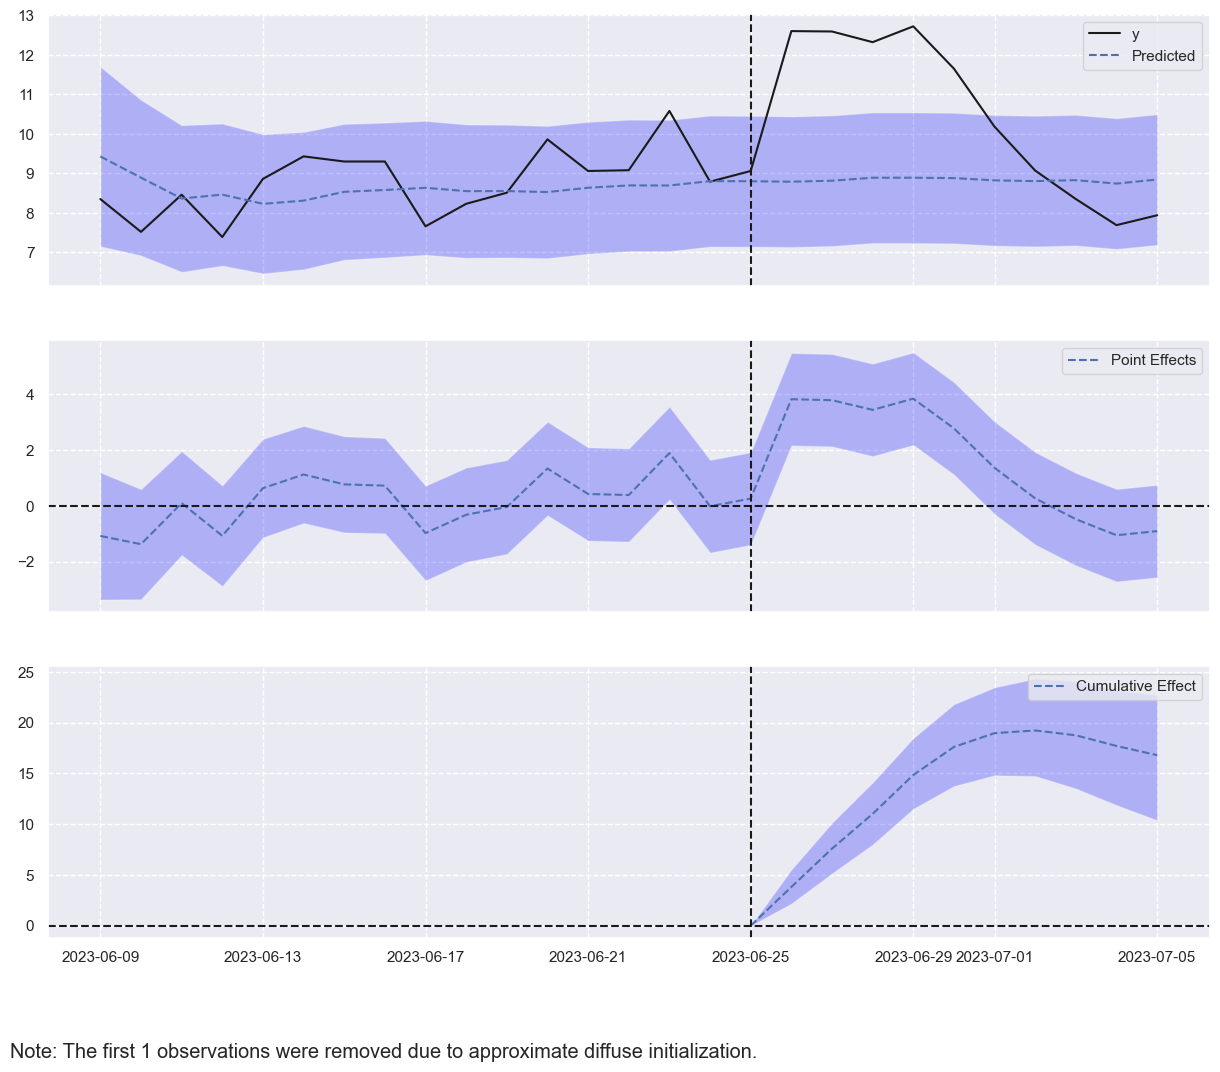

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    10.51              105.11
Prediction (s.d.)         8.83 (0.32)        88.3 (3.15)
95% CI                    [8.24, 9.47]       [82.37, 94.72]

Absolute effect (s.d.)    1.68 (0.32)        16.81 (3.15)
95% CI                    [1.04, 2.27]       [10.39, 22.74]

Relative effect (s.d.)    19.03% (3.57%)     19.03% (3.57%)
95% CI                    [11.76%, 25.76%]   [11.76%, 25.76%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [70]:
ci.plot()
print(ci.summary())    

In [33]:
ci.trained_model.params

sigma2.irregular    1.018350
sigma2.level        0.000144
beta.X              0.256198
dtype: float64

# Raised Fees

In [5]:
##pull data for main metrics
query_rev_per_visitor = f"""with a as (
select 
DISTINCT
metros.name as METRO_NAME
,date_trunc('DAY', dateadd(minute,0,dateadd(hour,0,jr.created_at))) as DAY
,jr.GUID as reco_guid
,case when jobs.id is NULL then NULL else jr.GUID end as jobs_guid
,case when ji.id is NULL then NULL else jr.GUID end as invoice_guid
,jr.recommendation_id 
,case when jobs.id is NULL then 0 else 1 end as job_booked
,case when ji.id is NULL then 0 else 1 end as invoiced
,ji.REVENUE_CENTS
,case when jr.is_first_booking then jr.GUID else NULL end as new_visitor
,case when jr.is_first_booking and jobs.id is not null then jr.GUID else NULL end as new_visitor_job

from job_recommendations jr
left join jobs on jobs.recommendation_id = jr.recommendation_id
LEFT JOIN job_invoices ji ON jobs.id = ji.job_id
LEFT JOIN geographies metros ON COALESCE(jr.metro_id, jr.geography_id)  = metros.id 

where 
jr.created_at >= '{data_start2}'
and  (jobs.suppress_level < 1000 OR jobs.suppress_level is NULL)
and jr.locale in {*locales,''}
and jr.category_id  in {*cat_ids2,}   ---- checking the not these
and metros.LEVEL = 'metro'
and metros.ACTIVE = 1
and (metros.name in {*test_metros2,} or metros.name in {*control_metros2,})
)

select
METRO_NAME
,DAY
,COUNT(DISTINCT reco_guid) as RECO_VISITORS_UNIQUE
,COUNT(DISTINCT jobs_guid) as JOBS_VISITORS_UNIQUE
,COUNT(DISTINCT invoice_guid) as INVOICE_VISITORS_UNIQUE
,COUNT(DISTINCT RECOMMENDATION_ID) as RECOS
,SUM(JOB_BOOKED) as JOBS
,SUM(invoiced) as INVOICES
,SUM(REVENUE_CENTS) as REVENUE
,COUNT(distinct new_visitor) as NEW_RECO_VISITORS
,COUNT(distinct new_visitor_job) as NEW_JOB_VISITORS
,COUNT(DISTINCT reco_guid) - COUNT(distinct new_visitor) as RETURN_RECO_VISITORS
,COUNT(DISTINCT jobs_guid) - COUNT(distinct new_visitor_job) as RETURN_JOB_VISITORS

from a 
group by 1,2
order by 2,4 desc"""

query_rates = f"""
with rates as (
select 
jr.created_at as created_at,
jr.recommendation_id,
jrr.POSITION,
jrr.category_invoice_count,
LEAST(jr.NUMBER_OF_RESULTS,50) as MAX_POSITION,
to_double(LEAST(jr.NUMBER_OF_RESULTS,50)) as FACES,
to_double(jrr.poster_hourly_rate_cents / 100.0) as client_rate,
to_double(jrr.rabbit_hourly_rate_cents / 100.0) as rabbit_rate,
to_double(jrr.RECOMMENDED_PRICE_CENTS / 100.0) as recommended_rate,
metros.name  as metro_name,
metros.id as metro_id

from job_recommendation_recommendations jrr 
LEFT JOIN job_recommendations jr ON jr.recommendation_id = jrr.recommendation_id
LEFT JOIN categories  ON jr.category_id  = categories.id
LEFT JOIN geographies  AS metros ON COALESCE(jr.metro_id, jr.geography_id)  = metros.id

WHERE jr.created_at  >= '{data_start2}' and
(jrr.position  < 50) AND (jr.locale in {*locales,''})
  AND jr.last_in_funnel
  and jr.category_id  in {*cat_ids2,}  ----- checking the not ins
),

rates_8 as (
select 
jr.created_at as created_at,
jr.recommendation_id,
jrr.POSITION,
jrr.category_invoice_count,
LEAST(jr.NUMBER_OF_RESULTS,50) as MAX_POSITION,
to_double(LEAST(jr.NUMBER_OF_RESULTS,50)) as FACES,
to_double(jrr.poster_hourly_rate_cents / 100.0) as client_rate,
to_double(jrr.rabbit_hourly_rate_cents / 100.0) as rabbit_rate,
to_double(jrr.RECOMMENDED_PRICE_CENTS / 100.0) as recommended_rate,
metros.name  as metro_name,
metros.id as metro_id

from job_recommendation_recommendations jrr 
LEFT JOIN job_recommendations jr ON jr.recommendation_id = jrr.recommendation_id
LEFT JOIN categories  ON jr.category_id  = categories.id
LEFT JOIN geographies  AS metros ON COALESCE(jr.metro_id, jr.geography_id)  = metros.id

WHERE jr.created_at  >= '{data_start2}' and
(jrr.position  < 9) AND (jr.locale in {*locales,''})
  AND jr.last_in_funnel
  and jr.category_id in {*cat_ids2,}  ----- checking the not ins
  and (metros.name in {*test_metros2,} or metros.name in {*control_metros2,})
)

select
date_trunc('day', rates.created_at) as day,
rates.recommendation_id,
rates.metro_name,
rates.metro_id,
sum(rates.rabbit_rate * w.invoice_pct) as rabbit_px_wt,
sum(rates.client_rate * w.invoice_pct) as client_px_wt,
sum(rates.recommended_rate * w.invoice_pct) as pg_px_wt,
sum(rates.category_invoice_count * w.invoice_pct) as wt_cat_experience, ---was weight not invpct
avg(rates.rabbit_rate) as rabbit_rate_avg,
avg(rates.client_rate) as client_rate_avg,
avg(rates.recommended_rate) as pg_rate_avg,
avg(rates.FACES) as FACES,
--avg(rates_8.recommended_rate) as pg_rate_top_8,
--avg(rates_8.rabbit_rate) as rabbit_rate_top_8
1 as pg_rate_top_8,
1 as rabbit_rate_top_8 ---- seeing if these were causing trouble

from
rates 
left join playground.JJC_INV_WGT w on w.number_of_results = rates.MAX_POSITION and w.POSITION2 = rates.POSITION
--left join rates_8 on rates.recommendation_id = rates_8.recommendation_id 
 group by 1,2,3,4
"""

query_invites = f"""
select
DISTINCT
metros.name as METRO_NAME
,date_trunc('DAY', dateadd(minute,0,dateadd(hour,0,jr.created_at))) as DAY
,jr.recommendation_id 
,case when jobs.id is NULL then 0 else 1 end as job_booked
,case when ji.id is NULL then 0 else 1 end as invoiced
,to_double(invitations.poster_hourly_rate_cents/100.0) as poster_hourly_rate_cents
,to_double(invitations.rabbit_hourly_rate_cents/100.0) as rabbit_hourly_rate_cents
,ji.REVENUE_CENTS
,pt.normalized_service_fee_in_cents + normalized_owner_trust_fee_in_cents + normalized_worker_fee_in_cents as ORDER_VALUE
,invitations.rabbit_category_experience
,jrr.recommended_price_cents as pg_rate_cents


from invitations 
LEFT JOIN job_recommendations jr ON jr.recommendation_id = invitations.recommendation_id 
left join jobs on jobs.recommendation_id = jr.recommendation_id
left join job_recommendation_recommendations jrr on jrr.recommendation_id = jr.recommendation_id 
        and invitations.rabbit_id = jrr.user_id
LEFT JOIN job_invoices ji ON jobs.id = ji.job_id
LEFT JOIN geographies metros ON COALESCE(jr.metro_id, jr.geography_id)  = metros.id 
LEFT JOIN payment_transactions pt ON pt.ID = ji.PAYMENT_TRANSACTION_ID

where last_in_funnel 
and jr.created_at >= '{data_start2}'
and jr.created_at < current_date()
and  (jobs.suppress_level < 1000 OR jobs.suppress_level is NULL)
and jr.locale in {*locales,''}
and jr.category_id  in {*cat_ids2,}  ----- checking the not ins
and (metros.name in {*test_metros2,} or metros.name in {*control_metros2,})

"""


In [6]:
def add_cohorts(df_rpv,test_metros2,control_metros2):
    df_rpv['COHORT'] = None
    df_rpv['COHORT'] = np.where(df_rpv.METRO_NAME.isin(test_metros2), 'TREATMENT',df_rpv.COHORT)
    df_rpv['COHORT'] = np.where(df_rpv.METRO_NAME.isin(control_metros2), 'CONTROL',df_rpv.COHORT)
    df_rpv = df_rpv[~df_rpv.COHORT.isna()]
    return df_rpv

In [7]:
def make_ts_df(df_rpv, df_rates, df_invites):
    """create experiment dataframe
       group by cohort/day to transform necessary variables
    """
    df_gb = pd.DataFrame(df_rpv.groupby(['COHORT','DAY'])['REVENUE'].sum()/df_rpv.groupby(['COHORT','DAY'])['RECO_VISITORS_UNIQUE'].sum()).reset_index()
    df_gb.columns = ['COHORT','DAY','REVENUE_PER_VISITOR']
    df_gb['REVENUE_PER_VISITOR'] = round(df_gb['REVENUE_PER_VISITOR'].astype(float) / 100,2)
    df_gb2 = pd.DataFrame(df_rpv.groupby(['COHORT','DAY'])['JOBS_VISITORS_UNIQUE'].sum()/df_rpv.groupby(['COHORT','DAY'])['RECO_VISITORS_UNIQUE'].sum()).reset_index()
    df_gb2.columns = ['COHORT','DAY','JOBS_RATE']
    df_gb21 = pd.DataFrame(df_rpv.groupby(['COHORT','DAY'])['JOBS_VISITORS_UNIQUE'].sum()/df_rpv.groupby(['COHORT','DAY'])['RECOS'].sum()).reset_index()
    df_gb21.columns = ['COHORT','DAY','JOBS_RATE2']
    df_gb3 = pd.DataFrame(df_rpv.groupby(['COHORT','DAY'])['INVOICE_VISITORS_UNIQUE'].sum()/df_rpv.groupby(['COHORT','DAY'])['RECO_VISITORS_UNIQUE'].sum()).reset_index()
    df_gb3.columns = ['COHORT','DAY','INVOICE_RATE']
    df_gb_cr = pd.DataFrame(df_rpv.groupby(['COHORT','DAY'])['INVOICE_VISITORS_UNIQUE'].sum()/df_rpv.groupby(['COHORT','DAY'])['JOBS_VISITORS_UNIQUE'].sum()).reset_index()
    df_gb_cr.columns = ['COHORT','DAY','CLOSE_RATE']
    df_gb4 = df_rates.groupby(['COHORT','DAY'], as_index = False)['PG_RATE_TOP_8','RABBIT_RATE_TOP_8','CLIENT_RATE_AVG','RABBIT_RATE_AVG','PG_RATE_AVG','CLIENT_PX_WT','RABBIT_PX_WT','PG_PX_WT','FACES','WT_CAT_EXPERIENCE'].mean()
    df_gb4 = df_gb4.rename(columns = {'CLIENT_RATE_AVG':'CLIENT_PX_SHOWN_AVG','RABBIT_RATE_AVG':'RABBIT_PX_SHOWN_AVG','PG_RATE_AVG':'PG_PX_SHOWN_AVG'})
    df_gb4 = df_gb4.rename(columns = {'CLIENT_PX_WT':'CLIENT_PX_SHOWN_WT','RABBIT_PX_WT':'RABBIT_PX_SHOWN_WT','PG_PX_WT':'PG_PX_SHOWN_WT','FACES':'AVG_FACES'})
    df_gb5 = df_invites.groupby(['COHORT','DAY'], as_index = False)[['ORDER_VALUE','POSTER_HOURLY_RATE_CENTS','RABBIT_HOURLY_RATE_CENTS','RABBIT_CATEGORY_EXPERIENCE','PG_RATE_CENTS']].mean()
    df_gb5 = df_gb5.rename(columns = {'PG_RATE_CENTS':'AVG_INVITE_PG','ORDER_VALUE':'AOV','POSTER_HOURLY_RATE_CENTS':'AVG_INVITE_CLIENT_PX','RABBIT_HOURLY_RATE_CENTS':'AVG_INVITE_RABBIT_PX','RABBIT_CATEGORY_EXPERIENCE':'AVG_INVITE_CAT_EXP'})
    df_tracking = df_gb.merge(df_gb2).merge(df_gb3).merge(df_rpv.groupby(['COHORT','DAY'], as_index = False)['RECOS','JOBS','INVOICES'].sum())
    df_tracking = df_tracking.merge(df_gb4).merge(df_gb5)
    df_tracking = df_tracking.merge(df_gb_cr, how = 'left')
    df_tracking = df_tracking.merge(pd.DataFrame(df_rpv.groupby(['COHORT','DAY'],as_index = False)['REVENUE'].sum()))
    df_gb_rr = pd.DataFrame(df_rpv.groupby(['COHORT','DAY'])['REVENUE'].sum()/df_rpv.groupby(['COHORT','DAY'])['RECOS'].sum()).reset_index()
    df_gb_rr.columns = ['COHORT','DAY','REVENUE_PER_RECO']
    df_tracking = df_tracking.merge(df_gb_rr, how = 'left')
    df_gbb = pd.DataFrame(df_rpv.groupby(['COHORT','DAY'])['RECOS'].sum()/df_rpv.groupby(['COHORT','DAY'])['RECO_VISITORS_UNIQUE'].sum()).reset_index()
    df_gbb.columns = ['COHORT','DAY','RECO_PER_VISITOR']
    df_tracking = df_tracking.merge(df_gbb, how = 'left')
    df_tracking = df_tracking.merge(df_gb21, how = 'left')
    return df_tracking

In [8]:
df_rpv = run_sql_query(query_rev_per_visitor)
df_rates = run_sql_query(query_rates)
df_invites = run_sql_query(query_invites)
df_rpv2 = add_cohorts(df_rpv,test_metros2,control_metros2)
df_rates2 = add_cohorts(df_rates,test_metros2,control_metros2)
df_invites2 = add_cohorts(df_invites, test_metros2,control_metros2)
df_exp = make_ts_df(df_rpv2,df_rates2,df_invites2)

In [9]:
def plot_cols(df_exp, col_name, experiment_date = test_start2, max_date = None):
    if max_date:
        df_exp2 = df_exp[df_exp.DAY <= max_date]
    else:
        
        df_exp2 = df_exp.copy()
    print(f'corr = {np.corrcoef(df_exp2[df_exp2.COHORT == "CONTROL"][col],df_exp2[df_exp2.COHORT == "TREATMENT"][col])[0][1]}')
    fig,ax = plt.subplots(figsize = (15,5))
    ax = sns.lineplot(data=df_exp2, x="DAY", y=col, hue="COHORT")
    if experiment_date:
        plt.axvline(x = pd.to_datetime(experiment_date), color='black')

corr = 0.5566204133463313


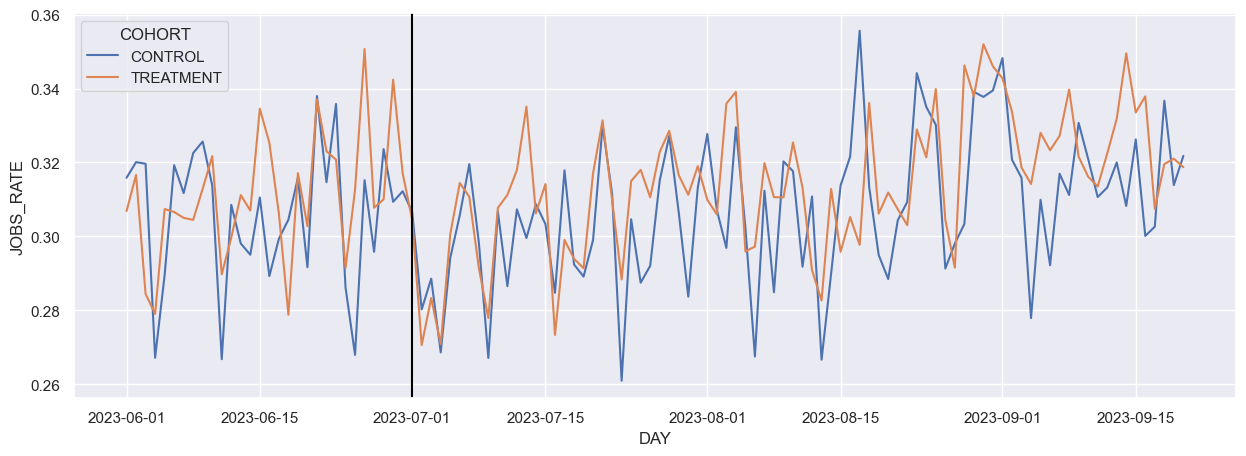

In [10]:
col =  'JOBS_RATE'
plot_cols(df_exp, col)

In [11]:
#get periods for pre and post
pre_period_start, pre_period_end, post_period_start, post_period_end = set_date_ranges(test_start2,test_end2,data_start2,df_exp, ratio = 2, baking_prd = 0)

In [18]:
#col = 'AVG_INVITE_RABBIT_PX'
#col = 'RABBIT_PX_SHOWN_WT'
#col = 'PG_PX_SHOWN_WT'

#col = 'JOBS_RATE'
#col = 'JOBS'
#col = 'REVENUE'
#col = 'REVENUE_PER_RECO'
col = 'INVOICE_RATE'
#col = 'AVG_INVITE_PG'

data = df_exp[df_exp.COHORT == 'TREATMENT'][['DAY',col]].rename(columns = {col:'y'}).set_index('DAY')
data = data.join(df_exp[df_exp.COHORT == 'CONTROL'][['DAY',col]].rename(columns = {col:'X'}).set_index('DAY'))
pre_period = [pre_period_start,pre_period_end]
post_period = [post_period_start,post_period_end]

ci = CausalImpact(data[['y','X']], pre_period, post_period, prior_level_sd = .01)
#ci = CausalImpact(data[['y','X']], pre_period, post_period, prior_level_sd=.01, nseasons = [{'period':7}])

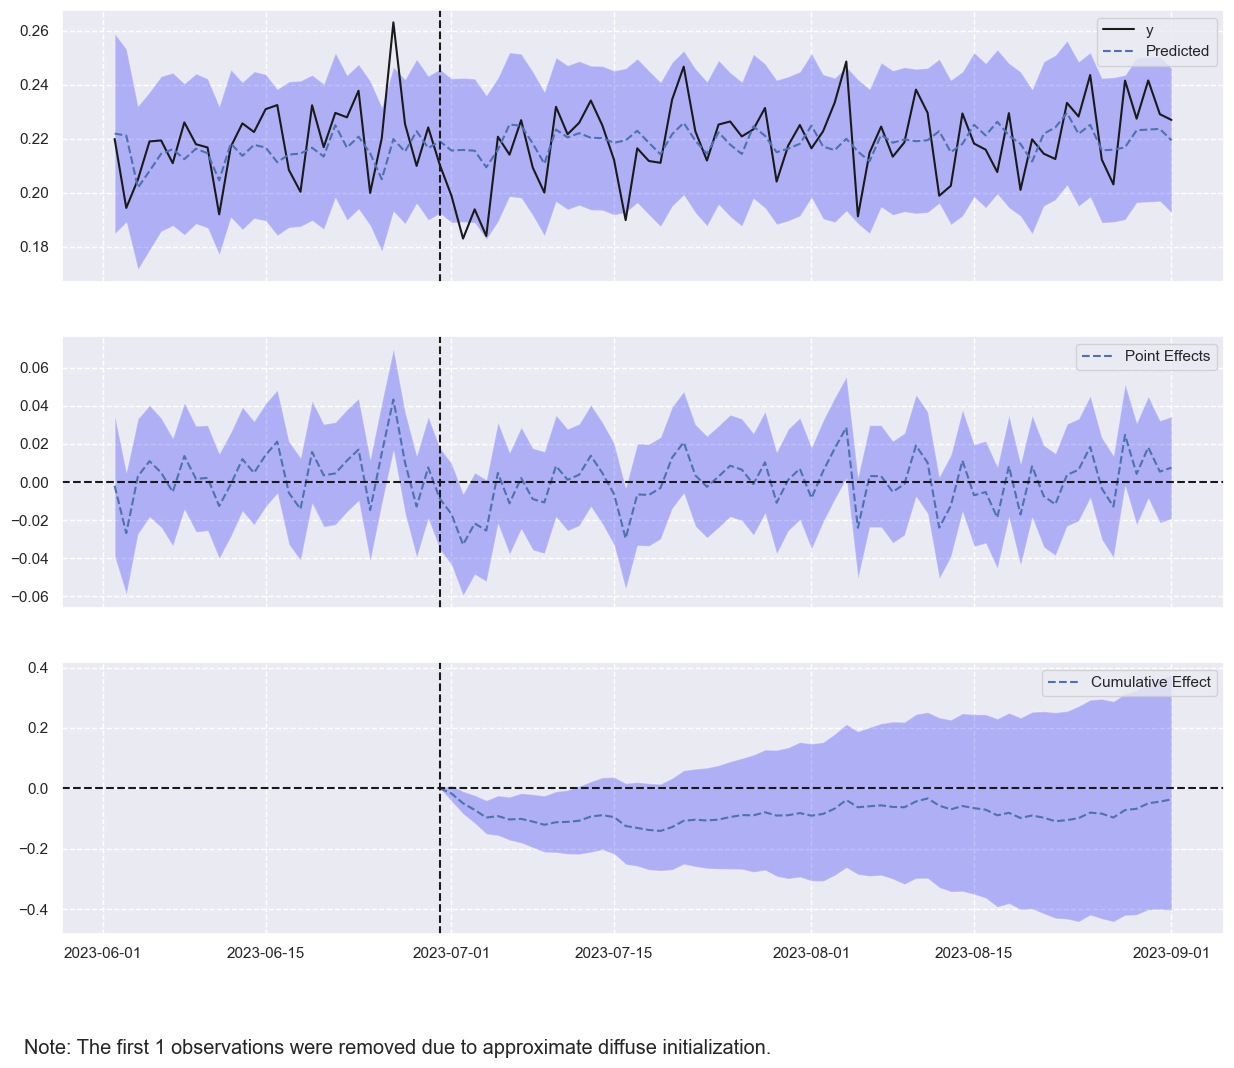

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.22               13.79
Prediction (s.d.)         0.22 (0.0)         13.83 (0.2)
95% CI                    [0.21, 0.23]       [13.42, 14.2]

Absolute effect (s.d.)    -0.0 (0.0)         -0.04 (0.2)
95% CI                    [-0.01, 0.01]      [-0.4, 0.38]

Relative effect (s.d.)    -0.26% (1.44%)     -0.26% (1.44%)
95% CI                    [-2.92%, 2.72%]    [-2.92%, 2.72%]

Posterior tail-area probability p: 0.45
Posterior prob. of a causal effect: 54.95%

For more details run the command: print(impact.summary('report'))


In [19]:
ci.plot()
print(ci.summary())    

# Lowered Fees

In [20]:
#parameters2
data_start2 = '2023-06-01'
test_start2 = '2023-07-01'
test_end2 = '2023-09-01'
locales = ['en-US']
test_metros3 = ['SF Bay Area','Washington DC', 'LA & OC', 'Chicago', 'Boston']
##test_metros= ['Washington DC','Atlanta','Boston','Austin','Dallas/Fort Worth','Denver','Las Vegas','Nashville']
#control_metros3 =  ['New York City']  
control_metros3 = ['Philadelphia','Dallas/Fort Worth','Denver','Atlanta','Seattle','Austin','Miami']
## other tier twos: Philadelphia, Houston, San Diego, Portland
##control_metros = ['Chicago','Phoenix','Philadelphia','Miami','San Diego','Seattle','Charlotte','Raleigh/Durham']
#cat_ids2 = [59,33]  
##cat_ids = [401, 8]  
##33cat_ids = [33,405,6] 
##cat_ids = '33' 

In [21]:
##pull data for main metrics
query_rev_per_visitor = f"""with a as (
select 
DISTINCT
metros.name as METRO_NAME
,date_trunc('DAY', dateadd(minute,0,dateadd(hour,0,jr.created_at))) as DAY
,jr.GUID as reco_guid
,case when jobs.id is NULL then NULL else jr.GUID end as jobs_guid
,case when ji.id is NULL then NULL else jr.GUID end as invoice_guid
,jr.recommendation_id 
,case when jobs.id is NULL then 0 else 1 end as job_booked
,case when ji.id is NULL then 0 else 1 end as invoiced
,ji.REVENUE_CENTS
,case when jr.is_first_booking then jr.GUID else NULL end as new_visitor
,case when jr.is_first_booking and jobs.id is not null then jr.GUID else NULL end as new_visitor_job

from job_recommendations jr
left join jobs on jobs.recommendation_id = jr.recommendation_id
LEFT JOIN job_invoices ji ON jobs.id = ji.job_id
LEFT JOIN geographies metros ON COALESCE(jr.metro_id, jr.geography_id)  = metros.id 

where 
jr.created_at >= '{data_start2}'
and  (jobs.suppress_level < 1000 OR jobs.suppress_level is NULL)
and jr.locale in {*locales,''}
 and ( 
  (metros.name in ('SF Bay Area', 'LA & OC', 'Washington DC', 'Chicago', 'Boston', 'New York City', 'Philadelphia','Dallas/Fort Worth','Denver','Atlanta','Seattle','Austin','Miami') 
  and jr.category_id  in (69, 113, 116, 63)) or
  (metros.name in ('SF Bay Area',  'Washington DC', 'Chicago', 'Boston', 'New York City', 'Philadelphia','Dallas/Fort Worth','Denver','Atlanta','Seattle','Austin','Miami')
  and jr.category_id in (405, 510))
  or (metros.name in ('LA & OC',  'Chicago', 'Boston', 'New York City', 'Philadelphia','Dallas/Fort Worth','Denver','Atlanta','Seattle','Austin','Miami') and jr.category_id in (8,33)  ) )
and metros.LEVEL = 'metro'
and metros.ACTIVE = 1
)

select
METRO_NAME
,DAY
,COUNT(DISTINCT reco_guid) as RECO_VISITORS_UNIQUE
,COUNT(DISTINCT jobs_guid) as JOBS_VISITORS_UNIQUE
,COUNT(DISTINCT invoice_guid) as INVOICE_VISITORS_UNIQUE
,COUNT(DISTINCT RECOMMENDATION_ID) as RECOS
,SUM(JOB_BOOKED) as JOBS
,SUM(invoiced) as INVOICES
,SUM(REVENUE_CENTS) as REVENUE
,COUNT(distinct new_visitor) as NEW_RECO_VISITORS
,COUNT(distinct new_visitor_job) as NEW_JOB_VISITORS
,COUNT(DISTINCT reco_guid) - COUNT(distinct new_visitor) as RETURN_RECO_VISITORS
,COUNT(DISTINCT jobs_guid) - COUNT(distinct new_visitor_job) as RETURN_JOB_VISITORS

from a 
group by 1,2
order by 2,4 desc"""

query_rates = f"""
with rates as (
select 
jr.created_at as created_at,
jr.recommendation_id,
jrr.POSITION,
jrr.category_invoice_count,
LEAST(jr.NUMBER_OF_RESULTS,50) as MAX_POSITION,
to_double(LEAST(jr.NUMBER_OF_RESULTS,50)) as FACES,
to_double(jrr.poster_hourly_rate_cents / 100.0) as client_rate,
to_double(jrr.rabbit_hourly_rate_cents / 100.0) as rabbit_rate,
to_double(jrr.RECOMMENDED_PRICE_CENTS / 100.0) as recommended_rate,
metros.name  as metro_name,
metros.id as metro_id

from job_recommendation_recommendations jrr 
LEFT JOIN job_recommendations jr ON jr.recommendation_id = jrr.recommendation_id
LEFT JOIN categories  ON jr.category_id  = categories.id
LEFT JOIN geographies  AS metros ON COALESCE(jr.metro_id, jr.geography_id)  = metros.id

WHERE jr.created_at  >= '{data_start2}' and
(jrr.position  < 50) AND (jr.locale in {*locales,''})
  AND jr.last_in_funnel
  and ( 
  (metros.name in ('SF Bay Area', 'LA & OC', 'Washington DC', 'Chicago', 'Boston', 'New York City', 'Philadelphia','Dallas/Fort Worth','Denver','Atlanta','Seattle','Austin','Miami') 
  and jr.category_id  in (69, 113, 116, 63)) or
  (metros.name in ('SF Bay Area',  'Washington DC', 'Chicago', 'Boston', 'New York City', 'Philadelphia','Dallas/Fort Worth','Denver','Atlanta','Seattle','Austin','Miami') and jr.category_id in (405, 510))
  or (metros.name in ('LA & OC',  'Chicago', 'Boston', 'New York City', 'Philadelphia','Dallas/Fort Worth','Denver','Atlanta','Seattle','Austin','Miami') and jr.category_id in (8,33)  ) )
),

rates_8 as (
select 
jr.created_at as created_at,
jr.recommendation_id,
jrr.POSITION,
jrr.category_invoice_count,
LEAST(jr.NUMBER_OF_RESULTS,50) as MAX_POSITION,
to_double(LEAST(jr.NUMBER_OF_RESULTS,50)) as FACES,
to_double(jrr.poster_hourly_rate_cents / 100.0) as client_rate,
to_double(jrr.rabbit_hourly_rate_cents / 100.0) as rabbit_rate,
to_double(jrr.RECOMMENDED_PRICE_CENTS / 100.0) as recommended_rate,
metros.name  as metro_name,
metros.id as metro_id

from job_recommendation_recommendations jrr 
LEFT JOIN job_recommendations jr ON jr.recommendation_id = jrr.recommendation_id
LEFT JOIN categories  ON jr.category_id  = categories.id
LEFT JOIN geographies  AS metros ON COALESCE(jr.metro_id, jr.geography_id)  = metros.id

WHERE jr.created_at  >= '{data_start2}' and
(jrr.position  < 9) AND (jr.locale in {*locales,''})
  AND jr.last_in_funnel
  and ( 
  (metros.name in ('SF Bay Area', 'LA & OC', 'Washington DC', 'Chicago', 'Boston', 'New York City', 'Philadelphia','Dallas/Fort Worth','Denver','Atlanta','Seattle','Austin','Miami') 
  and jr.category_id  in (69, 113, 116, 63)) or
  (metros.name in ('SF Bay Area',  'Washington DC', 'Chicago', 'Boston', 'New York City', 'Philadelphia','Dallas/Fort Worth','Denver','Atlanta','Seattle','Austin','Miami') and jr.category_id in (405, 510))
  or (metros.name in ('LA & OC',  'Chicago', 'Boston', 'New York City', 'Philadelphia','Dallas/Fort Worth','Denver','Atlanta','Seattle','Austin','Miami') and jr.category_id in (8,33)  ) )
)

select
date_trunc('day', rates.created_at) as day,
rates.recommendation_id,
rates.metro_name,
rates.metro_id,
sum(rates.rabbit_rate * w.invoice_pct) as rabbit_px_wt,
sum(rates.client_rate * w.invoice_pct) as client_px_wt,
sum(rates.recommended_rate * w.invoice_pct) as pg_px_wt,
sum(rates.category_invoice_count * w.invoice_pct) as wt_cat_experience, ---was weight not invpct
avg(rates.rabbit_rate) as rabbit_rate_avg,
avg(rates.client_rate) as client_rate_avg,
avg(rates.recommended_rate) as pg_rate_avg,
avg(rates.FACES) as FACES,
--avg(rates_8.recommended_rate) as pg_rate_top_8,
--avg(rates_8.rabbit_rate) as rabbit_rate_top_8
1 as pg_rate_top_8,
1 as rabbit_rate_top_8 ---- seeing if these were causing trouble

from
rates 
left join playground.JJC_INV_WGT w on w.number_of_results = rates.MAX_POSITION and w.POSITION2 = rates.POSITION
--left join rates_8 on rates.recommendation_id = rates_8.recommendation_id 
 group by 1,2,3,4
"""

query_invites = f"""
select
DISTINCT
metros.name as METRO_NAME
,date_trunc('DAY', dateadd(minute,0,dateadd(hour,0,jr.created_at))) as DAY
,jr.recommendation_id 
,case when jobs.id is NULL then 0 else 1 end as job_booked
,case when ji.id is NULL then 0 else 1 end as invoiced
,to_double(invitations.poster_hourly_rate_cents/100.0) as poster_hourly_rate_cents
,to_double(invitations.rabbit_hourly_rate_cents/100.0) as rabbit_hourly_rate_cents
,ji.REVENUE_CENTS
,pt.normalized_service_fee_in_cents + normalized_owner_trust_fee_in_cents + normalized_worker_fee_in_cents as ORDER_VALUE
,invitations.rabbit_category_experience
,jrr.recommended_price_cents as pg_rate_cents


from invitations 
LEFT JOIN job_recommendations jr ON jr.recommendation_id = invitations.recommendation_id 
left join jobs on jobs.recommendation_id = jr.recommendation_id
left join job_recommendation_recommendations jrr on jrr.recommendation_id = jr.recommendation_id 
        and invitations.rabbit_id = jrr.user_id
LEFT JOIN job_invoices ji ON jobs.id = ji.job_id
LEFT JOIN geographies metros ON COALESCE(jr.metro_id, jr.geography_id)  = metros.id 
LEFT JOIN payment_transactions pt ON pt.ID = ji.PAYMENT_TRANSACTION_ID

where last_in_funnel 
and jr.created_at >= '{data_start2}'
and jr.created_at < current_date()
and  (jobs.suppress_level < 1000 OR jobs.suppress_level is NULL)
and jr.locale in {*locales,''}
 and ( 
  (metros.name in ('SF Bay Area', 'LA & OC', 'Washington DC', 'Chicago', 'Boston', 'New York City', 'Philadelphia','Dallas/Fort Worth','Denver','Atlanta','Seattle','Austin','Miami') 
  and jr.category_id  in (69, 113, 116, 63)) or
  (metros.name in ('SF Bay Area',  'Washington DC', 'Chicago', 'Boston', 'New York City', 'Philadelphia','Dallas/Fort Worth','Denver','Atlanta','Seattle','Austin','Miami') and jr.category_id in (405, 510))
  or (metros.name in ('LA & OC',  'Chicago', 'Boston', 'New York City', 'Philadelphia','Dallas/Fort Worth','Denver','Atlanta','Seattle','Austin','Miami') and jr.category_id in (8,33)  ) )

"""


In [22]:
def add_cohorts(df_rpv,test_metros3,control_metros3):
    df_rpv['COHORT'] = None
    df_rpv['COHORT'] = np.where(df_rpv.METRO_NAME.isin(test_metros3), 'TREATMENT',df_rpv.COHORT)
    df_rpv['COHORT'] = np.where(df_rpv.METRO_NAME.isin(control_metros3), 'CONTROL',df_rpv.COHORT)
    df_rpv = df_rpv[~df_rpv.COHORT.isna()]
    return df_rpv

In [23]:
def make_ts_df(df_rpv, df_rates, df_invites):
    """create experiment dataframe
       group by cohort/day to transform necessary variables
    """
    df_gb = pd.DataFrame(df_rpv.groupby(['COHORT','DAY'])['REVENUE'].sum()/df_rpv.groupby(['COHORT','DAY'])['RECO_VISITORS_UNIQUE'].sum()).reset_index()
    df_gb.columns = ['COHORT','DAY','REVENUE_PER_VISITOR']
    df_gb['REVENUE_PER_VISITOR'] = round(df_gb['REVENUE_PER_VISITOR'].astype(float) / 100,2)
    df_gb2 = pd.DataFrame(df_rpv.groupby(['COHORT','DAY'])['JOBS_VISITORS_UNIQUE'].sum()/df_rpv.groupby(['COHORT','DAY'])['RECO_VISITORS_UNIQUE'].sum()).reset_index()
    df_gb2.columns = ['COHORT','DAY','JOBS_RATE']
    df_gb21 = pd.DataFrame(df_rpv.groupby(['COHORT','DAY'])['JOBS_VISITORS_UNIQUE'].sum()/df_rpv.groupby(['COHORT','DAY'])['RECOS'].sum()).reset_index()
    df_gb21.columns = ['COHORT','DAY','JOBS_RATE2']
    df_gb3 = pd.DataFrame(df_rpv.groupby(['COHORT','DAY'])['INVOICE_VISITORS_UNIQUE'].sum()/df_rpv.groupby(['COHORT','DAY'])['RECO_VISITORS_UNIQUE'].sum()).reset_index()
    df_gb3.columns = ['COHORT','DAY','INVOICE_RATE']
    df_gb_cr = pd.DataFrame(df_rpv.groupby(['COHORT','DAY'])['INVOICE_VISITORS_UNIQUE'].sum()/df_rpv.groupby(['COHORT','DAY'])['JOBS_VISITORS_UNIQUE'].sum()).reset_index()
    df_gb_cr.columns = ['COHORT','DAY','CLOSE_RATE']
    df_gb4 = df_rates.groupby(['COHORT','DAY'], as_index = False)['PG_RATE_TOP_8','RABBIT_RATE_TOP_8','CLIENT_RATE_AVG','RABBIT_RATE_AVG','PG_RATE_AVG','CLIENT_PX_WT','RABBIT_PX_WT','PG_PX_WT','FACES','WT_CAT_EXPERIENCE'].mean()
    df_gb4 = df_gb4.rename(columns = {'CLIENT_RATE_AVG':'CLIENT_PX_SHOWN_AVG','RABBIT_RATE_AVG':'RABBIT_PX_SHOWN_AVG','PG_RATE_AVG':'PG_PX_SHOWN_AVG'})
    df_gb4 = df_gb4.rename(columns = {'CLIENT_PX_WT':'CLIENT_PX_SHOWN_WT','RABBIT_PX_WT':'RABBIT_PX_SHOWN_WT','PG_PX_WT':'PG_PX_SHOWN_WT','FACES':'AVG_FACES'})
    df_gb5 = df_invites.groupby(['COHORT','DAY'], as_index = False)[['ORDER_VALUE','POSTER_HOURLY_RATE_CENTS','RABBIT_HOURLY_RATE_CENTS','RABBIT_CATEGORY_EXPERIENCE','PG_RATE_CENTS']].mean()
    df_gb5 = df_gb5.rename(columns = {'PG_RATE_CENTS':'AVG_INVITE_PG','ORDER_VALUE':'AOV','POSTER_HOURLY_RATE_CENTS':'AVG_INVITE_CLIENT_PX','RABBIT_HOURLY_RATE_CENTS':'AVG_INVITE_RABBIT_PX','RABBIT_CATEGORY_EXPERIENCE':'AVG_INVITE_CAT_EXP'})
    df_tracking = df_gb.merge(df_gb2).merge(df_gb3).merge(df_rpv.groupby(['COHORT','DAY'], as_index = False)['RECOS','JOBS','INVOICES'].sum())
    df_tracking = df_tracking.merge(df_gb4).merge(df_gb5)
    df_tracking = df_tracking.merge(df_gb_cr, how = 'left')
    df_tracking = df_tracking.merge(pd.DataFrame(df_rpv.groupby(['COHORT','DAY'],as_index = False)['REVENUE'].sum()))
    df_gb_rr = pd.DataFrame(df_rpv.groupby(['COHORT','DAY'])['REVENUE'].sum()/df_rpv.groupby(['COHORT','DAY'])['RECOS'].sum()).reset_index()
    df_gb_rr.columns = ['COHORT','DAY','REVENUE_PER_RECO']
    df_tracking = df_tracking.merge(df_gb_rr, how = 'left')
    df_gbb = pd.DataFrame(df_rpv.groupby(['COHORT','DAY'])['RECOS'].sum()/df_rpv.groupby(['COHORT','DAY'])['RECO_VISITORS_UNIQUE'].sum()).reset_index()
    df_gbb.columns = ['COHORT','DAY','RECO_PER_VISITOR']
    df_tracking = df_tracking.merge(df_gbb, how = 'left')
    df_tracking = df_tracking.merge(df_gb21, how = 'left')
    return df_tracking

In [24]:
df_rpv = run_sql_query(query_rev_per_visitor)
df_rates = run_sql_query(query_rates)
df_invites = run_sql_query(query_invites)
df_rpv2 = add_cohorts(df_rpv,test_metros3,control_metros3)
df_rates2 = add_cohorts(df_rates,test_metros3,control_metros3)
df_invites2 = add_cohorts(df_invites, test_metros3,control_metros3)
df_exp = make_ts_df(df_rpv2,df_rates2,df_invites2)

In [25]:
def plot_cols(df_exp, col_name, experiment_date = test_start2, max_date = None):
    if max_date:
        df_exp2 = df_exp[df_exp.DAY <= max_date]
    else:
        
        df_exp2 = df_exp.copy()
    print(f'corr = {np.corrcoef(df_exp2[df_exp2.COHORT == "CONTROL"][col],df_exp2[df_exp2.COHORT == "TREATMENT"][col])[0][1]}')
    fig,ax = plt.subplots(figsize = (15,5))
    ax = sns.lineplot(data=df_exp2, x="DAY", y=col, hue="COHORT")
    if experiment_date:
        plt.axvline(x = pd.to_datetime(experiment_date), color='black')

corr = 0.7045474151130873


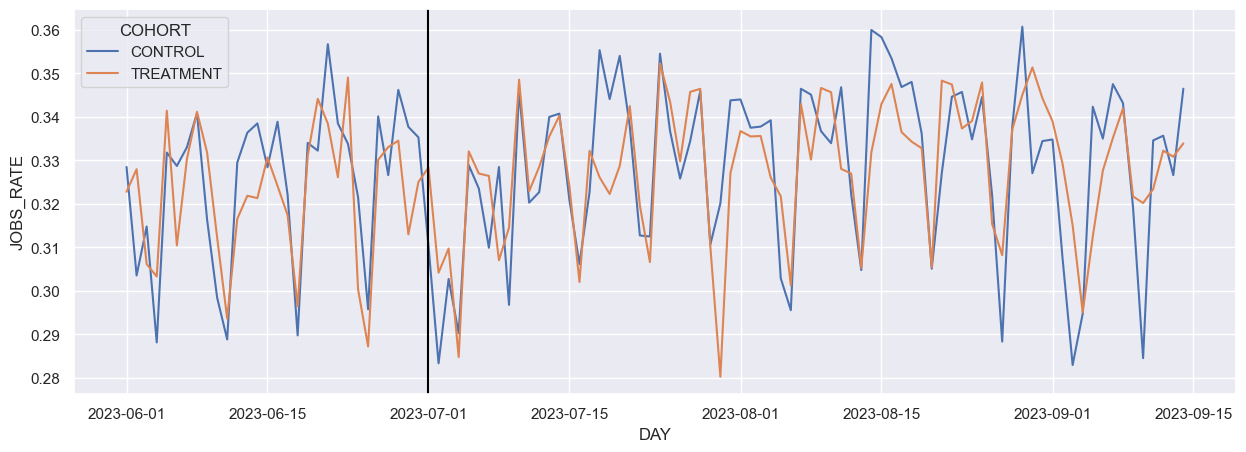

In [34]:
col =  'JOBS_RATE'
plot_cols(df_exp, col)

In [26]:
#get periods for pre and post
pre_period_start, pre_period_end, post_period_start, post_period_end = set_date_ranges(test_start2,test_end2,data_start2,df_exp, ratio = 2, baking_prd = 0)

In [31]:
#col = 'AVG_INVITE_RABBIT_PX'
#col = 'RABBIT_PX_SHOWN_WT'
#col = 'PG_PX_SHOWN_WT'

#col = 'JOBS_RATE'
#col = 'JOBS'
#col = 'REVENUE'
#col = 'REVENUE_PER_RECO'
col = 'INVOICE_RATE'
#col = 'AVG_INVITE_PG'

data = df_exp[df_exp.COHORT == 'TREATMENT'][['DAY',col]].rename(columns = {col:'y'}).set_index('DAY')
data = data.join(df_exp[df_exp.COHORT == 'CONTROL'][['DAY',col]].rename(columns = {col:'X'}).set_index('DAY'))
pre_period = [pre_period_start,pre_period_end]
post_period = [post_period_start,post_period_end]

ci = CausalImpact(data[['y','X']], pre_period, post_period, prior_level_sd = .01)
#ci = CausalImpact(data[['y','X']], pre_period, post_period, prior_level_sd=.01, nseasons = [{'period':7}])

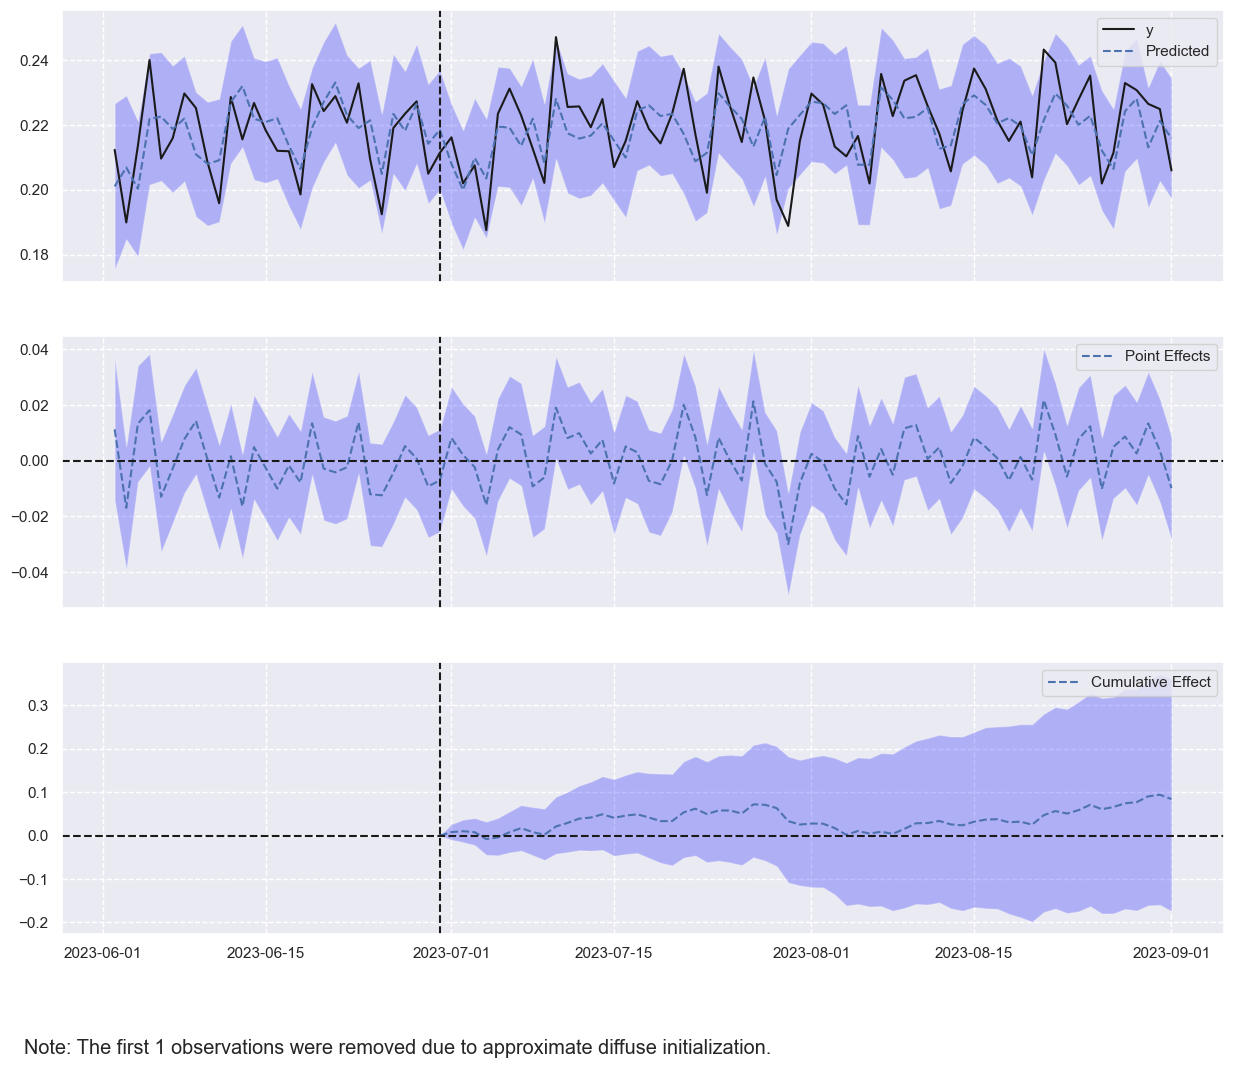

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.22               13.88
Prediction (s.d.)         0.22 (0.0)         13.79 (0.14)
95% CI                    [0.21, 0.22]       [13.52, 14.05]

Absolute effect (s.d.)    0.0 (0.0)          0.08 (0.14)
95% CI                    [-0.0, 0.01]       [-0.17, 0.36]

Relative effect (s.d.)    0.61% (0.99%)      0.61% (0.99%)
95% CI                    [-1.26%, 2.62%]    [-1.26%, 2.62%]

Posterior tail-area probability p: 0.27
Posterior prob. of a causal effect: 73.13%

For more details run the command: print(impact.summary('report'))


In [32]:
ci.plot()
print(ci.summary())    

# July


In [27]:
#parameters
data_start = '2023-05-25' ##2023-07-17 ## '2023-08-04'
test_start = '2023-08-24' ##'2023-07-24' ## 
test_end = '2023-09-03' ##'2023-08-02'##2023-08-02 ####
locales = ['en-US']
test_metros = ['SF Bay Area','Washington DC','Boston','Chicago', 'LA & OC', 'New York City']
##test_metros= ['Washington DC','Atlanta','Boston','Austin','Dallas/Fort Worth','Denver','Las Vegas','Nashville']
control_metros = ['Philadelphia','Dallas/Fort Worth','Denver','Atlanta','Seattle','Austin','Miami']
##control_metros = ['Chicago','Phoenix','Philadelphia','Miami','San Diego','Seattle','Charlotte','Raleigh/Durham']
cat_ids = [6,413]  
##cat_ids = [401, 8]  
##33cat_ids = [33,405,6] 
##cat_ids = '33' 

In [28]:
 #Function to get pre and post periods for CI and DiD
def set_date_ranges(test_start,test_end,data_start,df_exp, ratio = 2, baking_prd = 0):
    #make training period ratio*x testing period
    pre_period_start = pd.to_datetime(data_start) 
    if pre_period_start < pd.to_datetime(data_start):
        pre_period_start = pd.to_datetime(data_start)
    pre_period_start = pre_period_start.strftime('%Y-%m-%d')
    pre_period_end = (pd.to_datetime(test_start) - pd.Timedelta(days = 60)).strftime('%Y-%m-%d')
    post_period_start = test_start
    if pd.to_datetime(test_end) > pd.to_datetime(df_exp.DAY.max()):
        post_period_end = pd.to_datetime(df_exp.DAY.max()) - pd.Timedelta(days = baking_prd)
    else:
        post_period_end = pd.to_datetime(test_end) - pd.Timedelta(days = baking_prd)
    post_period_end = post_period_end.strftime('%Y-%m-%d')
    return pre_period_start, pre_period_end, post_period_start, post_period_end

In [29]:
##pull data for main metrics
query_rev_per_visitor = f"""with a as (
select 
DISTINCT
metros.name as METRO_NAME
,date_trunc('DAY', dateadd(minute,0,dateadd(hour,0,jr.created_at))) as DAY
,jr.GUID as reco_guid
,case when jobs.id is NULL then NULL else jr.GUID end as jobs_guid
,case when ji.id is NULL then NULL else jr.GUID end as invoice_guid
,jr.recommendation_id 
,case when jobs.id is NULL then 0 else 1 end as job_booked
,case when ji.id is NULL then 0 else 1 end as invoiced
,ji.REVENUE_CENTS
,case when jr.is_first_booking then jr.GUID else NULL end as new_visitor
,case when jr.is_first_booking and jobs.id is not null then jr.GUID else NULL end as new_visitor_job

from job_recommendations jr
left join jobs on jobs.recommendation_id = jr.recommendation_id
LEFT JOIN job_invoices ji ON jobs.id = ji.job_id
LEFT JOIN geographies metros ON COALESCE(jr.metro_id, jr.geography_id)  = metros.id 

where 
jr.created_at >= '{data_start}'
and jr.created_at <= '{test_end}'
and  (jobs.suppress_level < 1000 OR jobs.suppress_level is NULL)
and jr.locale in {*locales,''}
and jr.category_id  in {*cat_ids,}   ---- checking the not these
and metros.LEVEL = 'metro'
and metros.ACTIVE = 1 
and (metros.name in {*test_metros,} or metros.name in {*control_metros,})
)

select
METRO_NAME
,DAY
,COUNT(DISTINCT reco_guid) as RECO_VISITORS_UNIQUE
,COUNT(DISTINCT jobs_guid) as JOBS_VISITORS_UNIQUE
,COUNT(DISTINCT invoice_guid) as INVOICE_VISITORS_UNIQUE
,COUNT(DISTINCT RECOMMENDATION_ID) as RECOS
,SUM(JOB_BOOKED) as JOBS
,SUM(invoiced) as INVOICES
,SUM(REVENUE_CENTS) as REVENUE
,COUNT(distinct new_visitor) as NEW_RECO_VISITORS
,COUNT(distinct new_visitor_job) as NEW_JOB_VISITORS
,COUNT(DISTINCT reco_guid) - COUNT(distinct new_visitor) as RETURN_RECO_VISITORS
,COUNT(DISTINCT jobs_guid) - COUNT(distinct new_visitor_job) as RETURN_JOB_VISITORS

from a 
group by 1,2
order by 2,4 desc"""

query_rates = f"""
with rates as (
select 
jr.created_at as created_at,
jr.recommendation_id,
jrr.POSITION,
jrr.category_invoice_count,
LEAST(jr.NUMBER_OF_RESULTS,50) as MAX_POSITION,
to_double(LEAST(jr.NUMBER_OF_RESULTS,50)) as FACES,
to_double(jrr.poster_hourly_rate_cents / 100.0) as client_rate,
to_double(jrr.rabbit_hourly_rate_cents / 100.0) as rabbit_rate,
to_double(jrr.RECOMMENDED_PRICE_CENTS / 100.0) as recommended_rate,
metros.name  as metro_name,
metros.id as metro_id

from job_recommendation_recommendations jrr 
LEFT JOIN job_recommendations jr ON jr.recommendation_id = jrr.recommendation_id
LEFT JOIN categories  ON jr.category_id  = categories.id
LEFT JOIN geographies  AS metros ON COALESCE(jr.metro_id, jr.geography_id)  = metros.id

WHERE jr.created_at  >= '{data_start}' and
(jrr.position  < 50) AND (jr.locale in {*locales,''})
  AND jr.last_in_funnel
  and jr.category_id  in {*cat_ids,}  ----- checking the not ins
),

rates_8 as (
select 
jr.created_at as created_at,
jr.recommendation_id,
jrr.POSITION,
jrr.category_invoice_count,
LEAST(jr.NUMBER_OF_RESULTS,50) as MAX_POSITION,
to_double(LEAST(jr.NUMBER_OF_RESULTS,50)) as FACES,
to_double(jrr.poster_hourly_rate_cents / 100.0) as client_rate,
to_double(jrr.rabbit_hourly_rate_cents / 100.0) as rabbit_rate,
to_double(jrr.RECOMMENDED_PRICE_CENTS / 100.0) as recommended_rate,
metros.name  as metro_name,
metros.id as metro_id

from job_recommendation_recommendations jrr 
LEFT JOIN job_recommendations jr ON jr.recommendation_id = jrr.recommendation_id
LEFT JOIN categories  ON jr.category_id  = categories.id
LEFT JOIN geographies  AS metros ON COALESCE(jr.metro_id, jr.geography_id)  = metros.id

WHERE jr.created_at  >= '{data_start}' and
(jrr.position  < 9) AND (jr.locale in {*locales,''})
  AND jr.last_in_funnel
  and jr.category_id in {*cat_ids,}  ----- checking the not ins
)

select
date_trunc('day', rates.created_at) as day,
rates.recommendation_id,
rates.metro_name,
rates.metro_id,
sum(rates.rabbit_rate * w.invoice_pct) as rabbit_px_wt,
sum(rates.client_rate * w.invoice_pct) as client_px_wt,
sum(rates.recommended_rate * w.invoice_pct) as pg_px_wt,
sum(rates.category_invoice_count * w.invoice_pct) as wt_cat_experience, ---was weight not invpct
avg(rates.rabbit_rate) as rabbit_rate_avg,
avg(rates.client_rate) as client_rate_avg,
avg(rates.recommended_rate) as pg_rate_avg,
avg(rates.FACES) as FACES,
--avg(rates_8.recommended_rate) as pg_rate_top_8,
--avg(rates_8.rabbit_rate) as rabbit_rate_top_8
1 as pg_rate_top_8,
1 as rabbit_rate_top_8 ---- seeing if these were causing trouble

from
rates 
left join playground.JJC_INV_WGT w on w.number_of_results = rates.MAX_POSITION and w.POSITION2 = rates.POSITION
--left join rates_8 on rates.recommendation_id = rates_8.recommendation_id 
 group by 1,2,3,4
"""

query_invites = f"""
select
DISTINCT
metros.name as METRO_NAME
,date_trunc('DAY', dateadd(minute,0,dateadd(hour,0,jr.created_at))) as DAY
,jr.recommendation_id 
,case when jobs.id is NULL then 0 else 1 end as job_booked
,case when ji.id is NULL then 0 else 1 end as invoiced
,to_double(invitations.poster_hourly_rate_cents/100.0) as poster_hourly_rate_cents
,to_double(invitations.rabbit_hourly_rate_cents/100.0) as rabbit_hourly_rate_cents
,ji.REVENUE_CENTS
,pt.normalized_service_fee_in_cents + normalized_owner_trust_fee_in_cents + normalized_worker_fee_in_cents as ORDER_VALUE
,invitations.rabbit_category_experience
,jrr.recommended_price_cents as pg_rate_cents


from invitations 
LEFT JOIN job_recommendations jr ON jr.recommendation_id = invitations.recommendation_id 
left join jobs on jobs.recommendation_id = jr.recommendation_id
left join job_recommendation_recommendations jrr on jrr.recommendation_id = jr.recommendation_id 
        and invitations.rabbit_id = jrr.user_id
LEFT JOIN job_invoices ji ON jobs.id = ji.job_id
LEFT JOIN geographies metros ON COALESCE(jr.metro_id, jr.geography_id)  = metros.id 
LEFT JOIN payment_transactions pt ON pt.ID = ji.PAYMENT_TRANSACTION_ID

where last_in_funnel 
and jr.created_at >= '{data_start}'
and jr.created_at < current_date()
and  (jobs.suppress_level < 1000 OR jobs.suppress_level is NULL)
and jr.locale in {*locales,''}
and jr.category_id  in {*cat_ids,}  ----- checking the not ins
and (metros.name in {*test_metros,} or metros.name in {*control_metros,})

"""


In [30]:
def add_cohorts(df_rpv,test_metros,control_metros):
    df_rpv['COHORT'] = None
    df_rpv['COHORT'] = np.where(df_rpv.METRO_NAME.isin(test_metros), 'TREATMENT',df_rpv.COHORT)
    df_rpv['COHORT'] = np.where(df_rpv.METRO_NAME.isin(control_metros), 'CONTROL',df_rpv.COHORT)
    df_rpv = df_rpv[~df_rpv.COHORT.isna()]
    return df_rpv

In [32]:
def make_ts_df(df_rpv,  df_invites):
    """create experiment dataframe
       group by cohort/day to transform necessary variables
    """
    df_gb = pd.DataFrame(df_rpv.groupby(['COHORT','DAY'])['REVENUE'].sum()/df_rpv.groupby(['COHORT','DAY'])['RECO_VISITORS_UNIQUE'].sum()).reset_index()
    df_gb.columns = ['COHORT','DAY','REVENUE_PER_VISITOR']
    df_gb['REVENUE_PER_VISITOR'] = round(df_gb['REVENUE_PER_VISITOR'].astype(float) / 100,2)
    df_gb2 = pd.DataFrame(df_rpv.groupby(['COHORT','DAY'])['JOBS_VISITORS_UNIQUE'].sum()/df_rpv.groupby(['COHORT','DAY'])['RECO_VISITORS_UNIQUE'].sum()).reset_index()
    df_gb2.columns = ['COHORT','DAY','JOBS_RATE']
    df_gb21 = pd.DataFrame(df_rpv.groupby(['COHORT','DAY'])['JOBS_VISITORS_UNIQUE'].sum()/df_rpv.groupby(['COHORT','DAY'])['RECOS'].sum()).reset_index()
    df_gb21.columns = ['COHORT','DAY','JOBS_RATE2']
    df_gb3 = pd.DataFrame(df_rpv.groupby(['COHORT','DAY'])['INVOICE_VISITORS_UNIQUE'].sum()/df_rpv.groupby(['COHORT','DAY'])['RECO_VISITORS_UNIQUE'].sum()).reset_index()
    df_gb3.columns = ['COHORT','DAY','INVOICE_RATE']
    df_gb_cr = pd.DataFrame(df_rpv.groupby(['COHORT','DAY'])['INVOICE_VISITORS_UNIQUE'].sum()/df_rpv.groupby(['COHORT','DAY'])['JOBS_VISITORS_UNIQUE'].sum()).reset_index()
    df_gb_cr.columns = ['COHORT','DAY','CLOSE_RATE']
 ##   df_gb4 = df_rates.groupby(['COHORT','DAY'], as_index = False)['PG_RATE_TOP_8','RABBIT_RATE_TOP_8','CLIENT_RATE_AVG','RABBIT_RATE_AVG','PG_RATE_AVG','CLIENT_PX_WT','RABBIT_PX_WT','PG_PX_WT','FACES','WT_CAT_EXPERIENCE'].mean()
  ##  df_gb4 = df_gb4.rename(columns = {'CLIENT_RATE_AVG':'CLIENT_PX_SHOWN_AVG','RABBIT_RATE_AVG':'RABBIT_PX_SHOWN_AVG','PG_RATE_AVG':'PG_PX_SHOWN_AVG'})
  ##  df_gb4 = df_gb4.rename(columns = {'CLIENT_PX_WT':'CLIENT_PX_SHOWN_WT','RABBIT_PX_WT':'RABBIT_PX_SHOWN_WT','PG_PX_WT':'PG_PX_SHOWN_WT','FACES':'AVG_FACES'})
    df_gb5 = df_invites.groupby(['COHORT','DAY'], as_index = False)[['ORDER_VALUE','POSTER_HOURLY_RATE_CENTS','RABBIT_HOURLY_RATE_CENTS','RABBIT_CATEGORY_EXPERIENCE','PG_RATE_CENTS']].mean()
    df_gb5 = df_gb5.rename(columns = {'PG_RATE_CENTS':'AVG_INVITE_PG','ORDER_VALUE':'AOV','POSTER_HOURLY_RATE_CENTS':'AVG_INVITE_CLIENT_PX','RABBIT_HOURLY_RATE_CENTS':'AVG_INVITE_RABBIT_PX','RABBIT_CATEGORY_EXPERIENCE':'AVG_INVITE_CAT_EXP'})
    df_tracking = df_gb.merge(df_gb2).merge(df_gb3).merge(df_rpv.groupby(['COHORT','DAY'], as_index = False)['RECOS','JOBS','INVOICES'].sum())
    df_tracking = df_tracking.merge(df_gb5)
    df_tracking = df_tracking.merge(df_gb_cr, how = 'left')
    df_tracking = df_tracking.merge(pd.DataFrame(df_rpv.groupby(['COHORT','DAY'],as_index = False)['REVENUE'].sum()))
    df_gb_rr = pd.DataFrame(df_rpv.groupby(['COHORT','DAY'])['REVENUE'].sum()/df_rpv.groupby(['COHORT','DAY'])['RECOS'].sum()).reset_index()
    df_gb_rr.columns = ['COHORT','DAY','REVENUE_PER_RECO']
    df_gb_ri = pd.DataFrame(df_rpv.groupby(['COHORT','DAY'])['REVENUE'].sum()/df_rpv.groupby(['COHORT','DAY'])['INVOICES'].sum()).reset_index()
    df_gb_ri.columns = ['COHORT','DAY','REVENUE_PER_INVOICE']
    df_tracking = df_tracking.merge(df_gb_ri, how = 'left')
    df_tracking = df_tracking.merge(df_gb_rr, how = 'left')
    df_gbb = pd.DataFrame(df_rpv.groupby(['COHORT','DAY'])['RECOS'].sum()/df_rpv.groupby(['COHORT','DAY'])['RECO_VISITORS_UNIQUE'].sum()).reset_index()
    df_gbb.columns = ['COHORT','DAY','RECO_PER_VISITOR']
    df_tracking = df_tracking.merge(df_gbb, how = 'left')
    df_tracking = df_tracking.merge(df_gb21, how = 'left')
    return df_tracking

In [33]:
df_rpv = run_sql_query(query_rev_per_visitor)
##df_rates = run_sql_query(query_rates)
df_invites = run_sql_query(query_invites)
df_rpv2 = add_cohorts(df_rpv,test_metros,control_metros)
##df_rates2 = add_cohorts(df_rates,test_metros,control_metros)
df_invites2 = add_cohorts(df_invites, test_metros,control_metros)
df_exp = make_ts_df(df_rpv2,df_invites2)

In [34]:
#get periods for pre and post
pre_period_start, pre_period_end, post_period_start, post_period_end = set_date_ranges(test_start,test_end,data_start,df_exp, ratio = 2, baking_prd = 0)

In [51]:
#col = 'AVG_INVITE_RABBIT_PX'
#col = 'RABBIT_PX_SHOWN_WT'
#col = 'PG_PX_SHOWN_WT'
#col = 'REVENUE_PER_VISITOR'
col = 'JOBS_RATE'
#col = 'JOBS'
#col = 'REVENUE' 
#col = 'RECOS'
#col = 'REVENUE_PER_RECO'
#col = 'REVENUE_PER_INVOICE'
#col = 'INVOICE_RATE'
#col = 'AVG_INVITE_PG'

data = df_exp[df_exp.COHORT == 'TREATMENT'][['DAY',col]].rename(columns = {col:'y'}).set_index('DAY')
data = data.join(df_exp[df_exp.COHORT == 'CONTROL'][['DAY',col]].rename(columns = {col:'X'}).set_index('DAY'))
pre_period = [pre_period_start,pre_period_end]
post_period = [post_period_start,post_period_end]

ci = CausalImpact(data[['y','X']], pre_period, post_period, prior_level_sd = .01)
#ci = CausalImpact(data[['y','X']], pre_period, post_period, prior_level_sd=.01, nseasons = [{'period':7}])

In [19]:
#pre_period_start
post_period
#post_period_start
#post_period_end

['2023-08-25', '2023-09-03']

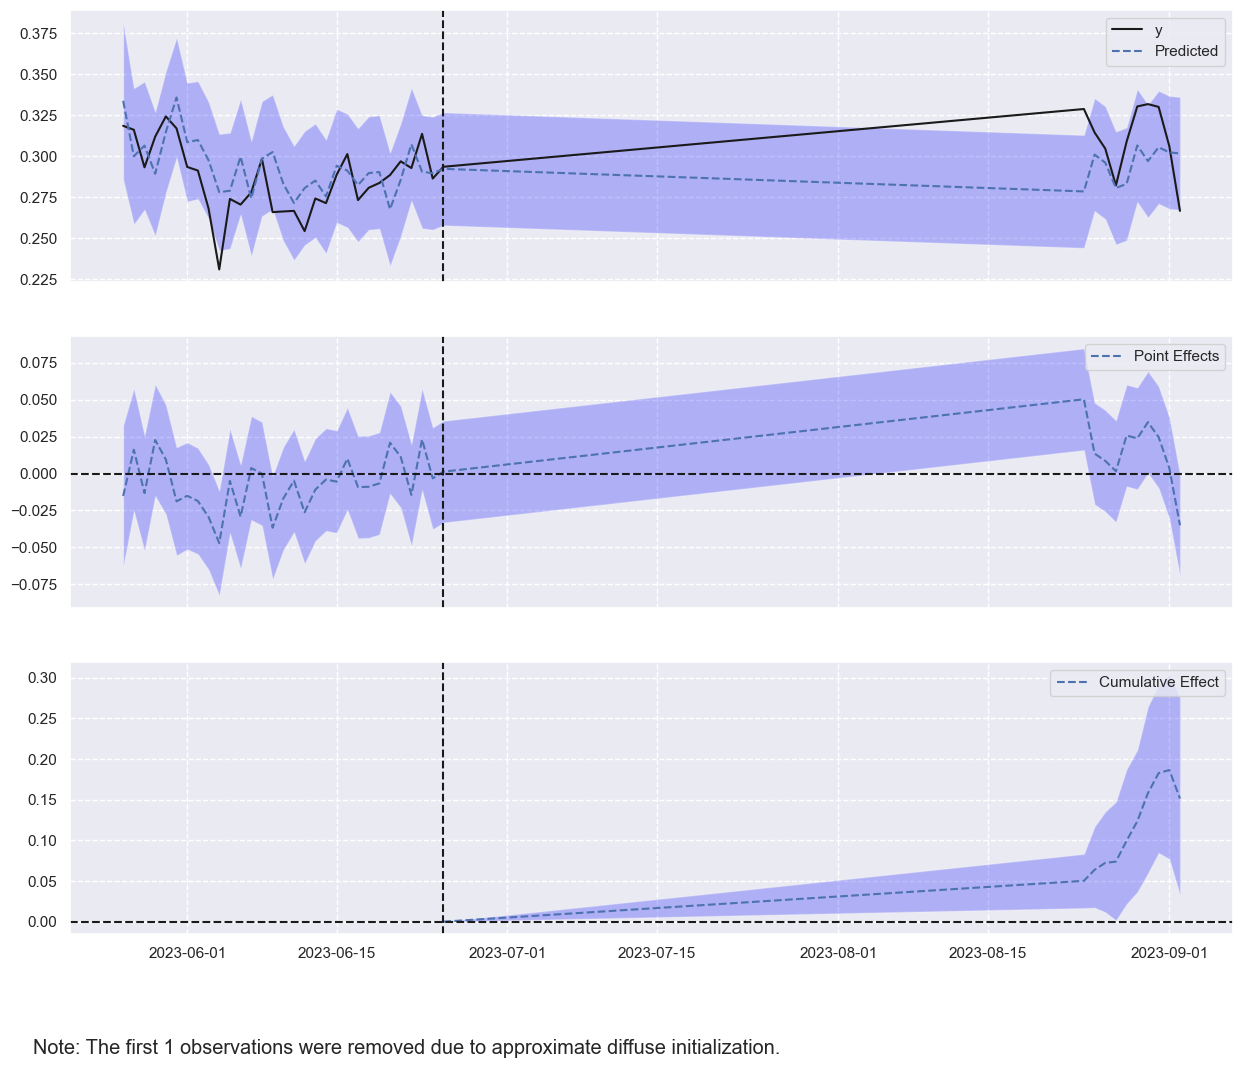

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.31               3.1
Prediction (s.d.)         0.3 (0.01)         2.95 (0.06)
95% CI                    [0.28, 0.31]       [2.83, 3.07]

Absolute effect (s.d.)    0.02 (0.01)        0.15 (0.06)
95% CI                    [0.0, 0.03]        [0.03, 0.28]

Relative effect (s.d.)    5.13% (2.1%)       5.13% (2.1%)
95% CI                    [1.1%, 9.33%]      [1.1%, 9.33%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.5%

For more details run the command: print(impact.summary('report'))


In [52]:
ci.plot()
print(ci.summary())   